In [37]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
import pylustrator
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.decomposition import PCA

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")


In [38]:
def find_cov_matrix(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'covariance_matrix.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'covariance_matrix.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths


all_cov_paths = find_cov_matrix(os.path.join(ROOT_DIR, "results", "case-studies"))
all_cov_dfs = []




for path in all_cov_paths:
    if 'scaleTesting' in path:
        continue
    cov_master_df = pd.DataFrame(columns=['dataset', 'transform', 'subset', 'channel', 'orientation', 'dataset_type'], index=[0])

    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    elif parts[0] == 'results':
        parts = parts[2:]
    if "MRI" in path and "gabor" not in path:
        dataset, slice, transform, orientation, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = slice
        cov_master_df['channel'] = np.nan
        cov_master_df['orientation'] = orientation
    elif "MRI" in path and "gabor" in path:
        dataset, slice, transform, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = slice
        cov_master_df['channel'] = np.nan
        cov_master_df['orientation'] = np.nan
       
    elif "gabor" in path:
        dataset, subset, transform, channel, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = np.nan
       
       
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = orientation
       
    elif "learned" in path:
        dataset, subset, transform, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df = cov_master_df.rename(columns={'filter_group' : 'orientation'})
        cov_master_df['channel'] = np.nan
       

    else:
        dataset, size, transform, channel, _, _ = parts
        
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = size
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = np.nan
       
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        cov_master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        cov_master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything']:
        cov_master_df['dataset_type'] = 'natural'
    elif dataset in ['standardTesting']:
        cov_master_df['dataset_type'] = 'classical'
    if transform == "gabor":
        cov_matrix = pd.read_csv(path[:-26] + "CSVs" + os.sep + "covariance_matrix.csv").drop(columns=['index'], axis = 1).to_numpy()
    else:
        cov_matrix = pd.read_csv(path[:-26] + "CSVs" + os.sep + "covariance_matrix.csv").drop(columns=['Unnamed: 0'], axis = 1).to_numpy()
        
   
    pca = PCA()
    
    pca.fit(cov_matrix)
    eigenvectors = pca.components_
    group_num = eigenvectors.shape[0]

    cov_master_df["fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix)))/group_num**2
    cov_master_df["rel_fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix))) / np.linalg.trace(cov_matrix)
    cos_dist = distance.cdist(eigenvectors, np.eye(group_num), metric='cosine')
    min_cos_dist = [np.min(row) for row in cos_dist.T]
    arg_min_cos_dist = [np.argmin(row) for row in cos_dist.T]
    cov_master_df["cov_matrix"] = [cov_matrix]
    cov_master_df["pca_comp"] = [arg_min_cos_dist]
    cov_master_df["cosine_dist"] = [min_cos_dist]
    cov_master_df["num_groups"] = group_num
    all_cov_dfs.append(cov_master_df)
    
cov_main_df = pd.concat(all_cov_dfs)


In [39]:
cov_main_df["max_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.max(x))

cov_main_df["median_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.median(x))
cov_main_df["75_percentile_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 75))
cov_main_df["90_percentile_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 90))


In [40]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

cov_main_df['dataset'] = (cov_main_df['dataset'] + cov_main_df['subset']).replace(name_mapping)

In [41]:
cov_main_df["pca_val_max_cosine_dist"] = cov_main_df.apply(
    lambda row: row["pca_comp"][np.argmax(row["cosine_dist"])], axis=1
)

In [42]:
np.unique(cov_main_df["dataset"])

array(['agriVision', 'coco (indoor)', 'coco (outdoor)', 'pastis',
       'segmentAnything', 'spaceNet', 'standardTesting',
       'syntheticMRI2D (axial)', 'syntheticMRI2D (coronal)',
       'syntheticMRI2D (sagittal)', 'syntheticMRI3D'], dtype=object)

In [43]:
granularity1 = ['transform', 'dataset_type', 'dataset']
summary_df1 = cov_main_df[np.append(granularity1, ["num_groups", "rel_fro_norm", "median_cosine_dist",  "90_percentile_cosine_dist", "max_cosine_dist"])].groupby(granularity1
    ).agg({
        #"fro_norm": "mean",
        "num_groups": "mean",
        "rel_fro_norm": "mean",
        
        #"cosine_dist": lambda x: np.concatenate(x.values)
        "median_cosine_dist":"mean",
        #"75_percentile_cosine_dist":"mean",
        "90_percentile_cosine_dist":"mean",
        "max_cosine_dist":"mean"
    })
summary_df1


num_groups  rel_fro_norm  \
transform dataset_type   dataset                                               
fourier   remote sensing agriVision                       32.0      0.000030   
                         pastis                           32.0      0.000032   
                         spaceNet                         23.0      0.000025   
gabor     medical        syntheticMRI2D (coronal)         42.0      0.000030   
                         syntheticMRI2D (sagittal)        42.0      0.000030   
          natural        coco (indoor)                    42.0      0.000030   
                         coco (outdoor)                   42.0      0.000030   
                         segmentAnything                  42.0      0.000030   
          remote sensing agriVision                       42.0      0.000030   
                         pastis                           42.0      0.000030   
                         spaceNet                         42.0      0.000030   
learned   classical      standardTesting                  54.0      0.000032   
          natural        coco (indoor)                    62.0      0.000032   
                         coco (outdoor)                   64.0      0.000031   
                         segmentAnything                  61.0      0.000031   
          remote sensing agriVision                       60.0      0.000032   
                         pastis                           32.0      0.000032   
                         spaceNet                         56.0      0.000030   
wavelet   classical      standardTesting                   7.0      0.000015   
          medical        syntheticMRI2D (axial)            7.0      0.000010   
                         syntheticMRI2D (coronal)          7.0      0.000024   
                         syntheticMRI2D (sagittal)         7.0      0.000012   
                         syntheticMRI3D                    6.0      0.000034   
          natural        coco (indoor)                     8.0      0.000023   
                         coco (outdoor)                    8.0      0.000006   
                         segmentAnything                   9.0      0.000010   
          remote sensing agriVision                        9.0      0.000017   
                         pastis                            7.0      0.000017   
                         spaceNet                          8.0      0.000015   

                                                    median_cosine_dist  \
transform dataset_type   dataset                                         
fourier   remote sensing agriVision                           0.052134   
                         pastis                               0.027153   
                         spaceNet                             0.013745   
gabor     medical        syntheticMRI2D (coronal)             0.044536   
                         syntheticMRI2D (sagittal)            0.116799   
          natural        coco (indoor)                        0.145821   
                         coco (outdoor)                       0.166059   
                         segmentAnything                      0.172565   
          remote sensing agriVision                           0.127968   
                         pastis                               0.165993   
                         spaceNet                             0.186105   
learned   classical      standardTesting                      0.221993   
          natural        coco (indoor)                        0.230279   
                         coco (outdoor)                       0.230689   
                         segmentAnything                      0.218446   
          remote sensing agriVision                           0.194980   
                         pastis                               0.226985   
                         spaceNet                             0.216815   
wavelet   classical      standardTesting                      0.003569   
          medical

In [44]:
granularity2 = ['transform', 'dataset_type']
summary_df2 = cov_main_df[np.append(granularity2, [ "num_groups", "rel_fro_norm",  "median_cosine_dist", "90_percentile_cosine_dist","max_cosine_dist"])].groupby(granularity2
    ).agg({
        #"fro_norm": "mean",
        "num_groups": "mean",
        "rel_fro_norm": "mean",
        #"cosine_dist": lambda x: np.concatenate(x.values)
        "median_cosine_dist":"mean",
        #"75_percentile_cosine_dist":"mean",
        "90_percentile_cosine_dist":"mean",
        "max_cosine_dist":"mean"
    })

summary_df2
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df1, summary_df2]).reset_index()
summary_df_final
summary_df_final

transform    dataset_type                    dataset  num_groups  \
0    fourier  remote sensing                 agriVision   32.000000   
1    fourier  remote sensing                     pastis   32.000000   
2    fourier  remote sensing                   spaceNet   23.000000   
3      gabor         medical   syntheticMRI2D (coronal)   42.000000   
4      gabor         medical  syntheticMRI2D (sagittal)   42.000000   
5      gabor         natural              coco (indoor)   42.000000   
6      gabor         natural             coco (outdoor)   42.000000   
7      gabor         natural            segmentAnything   42.000000   
8      gabor  remote sensing                 agriVision   42.000000   
9      gabor  remote sensing                     pastis   42.000000   
10     gabor  remote sensing                   spaceNet   42.000000   
11   learned       classical            standardTesting   54.000000   
12   learned         natural              coco (indoor)   62.000000   
13   learned         natural             coco (outdoor)   64.000000   
14   learned         natural            segmentAnything   61.000000   
15   learned  remote sensing                 agriVision   60.000000   
16   learned  remote sensing                     pastis   32.000000   
17   learned  remote sensing                   spaceNet   56.000000   
18   wavelet       classical            standardTesting    7.000000   
19   wavelet         medical     syntheticMRI2D (axial)    7.000000   
20   wavelet         medical   syntheticMRI2D (coronal)    7.000000   
21   wavelet         medical  syntheticMRI2D (sagittal)    7.000000   
22   wavelet         medical             syntheticMRI3D    6.000000   
23   wavelet         natural              coco (indoor)    8.000000   
24   wavelet         natural             coco (outdoor)    8.000000   
25   wavelet         natural            segmentAnything    9.000000   
26   wavelet  remote sensing                 agriVision    9.000000   
27   wavelet  remote sensing                     pastis    7.000000   
28   wavelet  remote sensing                   spaceNet    8.000000   
29   fourier  remote sensing                z_aggregate   29.000000   
30     gabor         medical                z_aggregate   42.000000   
31     gabor         natural                z_aggregate   42.000000   
32     gabor  remote sensing                z_aggregate   42.000000   
33   learned       classical                z_aggregate   54.000000   
34   learned         natural                z_aggregate   62.333333   
35   learned  remote sensing                z_aggregate   49.333333   
36   wavelet       classical                z_aggregate    7.000000   
37   wavelet         medical                z_aggregate    6.562500   
38   wavelet         natural                z_aggregate    8.333333   
39   wavelet  remote sensing                z_aggregate    8.000000   

    rel_fro_norm  median_cosine_dist  90_percentile_cosine_dist  \
0       0.000030            0.052134                   0.175133   
1       0.000032            0.027153                   0.069650   
2       0.000025            0.013745                   0.139494   
3       0.000030            0.044536                   0.259543   
4       0.000030            0.116799                   0.296488   
5       0.000030            0.145821                   0.307514   
6       0.000030            0.166059                   0.302578   
7       0.000030            0.172565                   0.355219   
8       0.000030            0.127968                   0.292473   
9       0.000030            0.165993                   0.339444   
10      0.000030            0.186105                   0.367483   
11      0.000032            0.221993                   0.420719   
12      0.000032            0.230279                   0.432970   
13      0.000031            0.230689                   0.436247   
14      0.000031            0.218446                   0.389540   
15      0.000032   

In [45]:
summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'wavelet', 'gabor', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final =summary_df_final.rename(columns={
    'num_groups': 'Number of Groups',
    'rel_fro_norm': 'Relative Frobenius Norm',
    
    'median_cosine_dist': 'Median Cosine Distance',
    #'75_percentile_cosine_dist': '75th Percentile Cosine Distance',
    '90_percentile_cosine_dist': '90th Percentile Cosine Distance',
    'max_cosine_dist': 'Max Cosine Distance'
})

cols_to_round = [
    'Number of Groups',
    'Median Cosine Distance',
    '90th Percentile Cosine Distance',
    'Max Cosine Distance'
]
summary_df_final[cols_to_round] = summary_df_final[cols_to_round].round(4)

summary_df_final.to_csv(os.path.join(plots_path, 'independence_results_table.csv'))
summary_df_final

transform    dataset_type                    dataset  Number of Groups  \
0    fourier  remote sensing                 agriVision           32.0000   
1    fourier  remote sensing                     pastis           32.0000   
2    fourier  remote sensing                   spaceNet           23.0000   
29   fourier  remote sensing                z_aggregate           29.0000   
18   wavelet       classical            standardTesting            7.0000   
36   wavelet       classical                z_aggregate            7.0000   
19   wavelet         medical     syntheticMRI2D (axial)            7.0000   
20   wavelet         medical   syntheticMRI2D (coronal)            7.0000   
21   wavelet         medical  syntheticMRI2D (sagittal)            7.0000   
22   wavelet         medical             syntheticMRI3D            6.0000   
37   wavelet         medical                z_aggregate            6.5625   
23   wavelet         natural              coco (indoor)            8.0000   
24   wavelet         natural             coco (outdoor)            8.0000   
25   wavelet         natural            segmentAnything            9.0000   
38   wavelet         natural                z_aggregate            8.3333   
26   wavelet  remote sensing                 agriVision            9.0000   
27   wavelet  remote sensing                     pastis            7.0000   
28   wavelet  remote sensing                   spaceNet            8.0000   
39   wavelet  remote sensing                z_aggregate            8.0000   
3      gabor         medical   syntheticMRI2D (coronal)           42.0000   
4      gabor         medical  syntheticMRI2D (sagittal)           42.0000   
30     gabor         medical                z_aggregate           42.0000   
5      gabor         natural              coco (indoor)           42.0000   
6      gabor         natural             coco (outdoor)           42.0000   
7      gabor         natural            segmentAnything           42.0000   
31     gabor         natural                z_aggregate           42.0000   
8      gabor  remote sensing                 agriVision           42.0000   
9      gabor  remote sensing                     pastis           42.0000   
10     gabor  remote sensing                   spaceNet           42.0000   
32     gabor  remote sensing                z_aggregate           42.0000   
11   learned       classical            standardTesting           54.0000   
33   learned       classical                z_aggregate           54.0000   
12   learned         natural              coco (indoor)           62.0000   
13   learned         natural             coco (outdoor)           64.0000   
14   learned         natural            segmentAnything           61.0000   
34   learned         natural                z_aggregate           62.3333   
15   learned  remote sensing                 agriVision           60.0000   
16   learned  remote sensing                     pastis           32.0000   
17   learned  remote sensing                   spaceNet           56.0000   
35   learned  remote sensing                z_aggregate           49.3333   

    Relative Frobenius Norm  Median Cosine Distance  \
0                  0.000030                  0.0521   
1                  0.000032                  0.0272   
2                  0.000025                  0.0137   
29                 0.000029                  0.0310   
18                 0.000015                  0.0036   
36                 0.000015                  0.0036   
19                 0.000010                  0.0059   
20                 0.000024                  0.0064   
21                 0.000012                  0.0098   
22                 0.000034                  0.0041   
37                 0.000024                  0.0059   
23                 0.000023                  0.0021   
24                 0.000006                  0.0032   
25                 0.000010                  0.0031   
38                 0

In [46]:
cov_main_df.sort_values(by=["max_cosine_dist"], ascending=False)

dataset transform   subset channel orientation  \
0            standardTesting   learned     full     NaN         NaN   
0                   spaceNet   learned     full     NaN         NaN   
0                 agriVision   learned     full     NaN         NaN   
0             coco (outdoor)   learned  outdoor     NaN         NaN   
0              coco (indoor)   learned   indoor     NaN         NaN   
..                       ...       ...      ...     ...         ...   
0                     pastis   wavelet     full    gray    diagonal   
0             syntheticMRI3D   wavelet     full     NaN         dad   
0                     pastis   wavelet     full     red    diagonal   
0   syntheticMRI2D (coronal)   wavelet  coronal     NaN    vertical   
0             syntheticMRI3D   wavelet     full     NaN         aad   

      dataset_type  fro_norm  rel_fro_norm  \
0        classical  0.000002      0.000032   
0   remote sensing  0.000021      0.000030   
0   remote sensing  0.000043      0.000032   
0          natural  0.000002      0.000031   
0          natural  0.000002      0.000032   
..             ...       ...           ...   
0   remote sensing  0.000577      0.000019   
0          medical  1.738852      0.000034   
0   remote sensing  0.000757      0.000019   
0          medical  0.719603      0.000024   
0          medical  8.991453      0.000031   

                                           cov_matrix  \
0   [[4.917618320788004, -0.0001632892189132, -5.3...   
0   [[57.207309634391024, 0.0012772476649017, -7.2...   
0   [[105.79699780783288, -0.0031894696574656, -0....   
0   [[5.585184914626384, 3.4278331308006026e-05, -...   
0   [[4.719898290624506, -0.0001335852911755, 0.00...   
..                                                ...   
0   [[1072.0086651481702, 0.002333803871572, 0.018...   
0   [[1177878.966759853, -43.908919420273975, 3.30...   
0   [[1389.1300170718644, 0.0018619141245075, 0.02...   
0   [[946850.547172709, 22.07649902169089, -0.2779...   
0   [[8807416.644815315, -228.29816954996295, 4.71...   

                                             pca_comp  \
0   [10, 3, 32, 0, 1, 22, 30, 53, 49, 26, 27, 53, ...   
0   [12, 1, 40, 0, 13, 20, 38, 55, 49, 29, 25, 17,...   
0   [12, 4, 31, 5, 30, 37, 21, 59, 51, 36, 44, 43,...   
0   [18, 10, 9, 26, 3, 16, 48, 37, 62, 46, 36, 57,...   
0   [18, 5, 9, 28, 3, 16, 46, 23, 61, 45, 38, 52, ...   
..                                                ...   
0                               [0, 1, 2, 3, 4, 5, 6]   
0                                  [0, 1, 2, 3, 4, 5]   
0                               [0, 1, 2, 3, 4, 5, 6]   
0                               [0, 1, 2, 3, 4, 5, 6]   
0                                  [0, 1, 2, 3, 4, 5]   

                                          cosine_dist  num_groups  \
0   [0.20463032494603295, 0.06410720270495152, 0.6...          54   
0   [0.2123100080600564, 0.03281526077089758, 0.21...          56   
0   [0.3268706020285652, 0.00970961540722215, 0.14...          60   
0   [0.45418704142443067, 0.12066436263226532, 0.0...          64   
0   [0.07949505828132453, 0.010919443919802152, 0....          62   
..                                                ...         ...   
0   [0.0016497682124395618, 0.0030285486893049107,...           7   
0   [0.0071158361123742075, 0.007835469565315778, ...           6   
0   [0.0017918996674231025, 0.0031365453737177695,...           7   
0   [0.0035884265628040035, 0.005606282168073129, ...           7   
0   [0.0005712311725701857, 0.002140807355840102, ...           6   

    max_cosine_dist  median_cosine_dist  75_percentile_cosine_dist  \
0          0.955735            0.221993                   0.288092   
0          0.920413            0.216815                   0.296705   
0          0.912715            0.194980                   0.284944   
0          0.897622            0.230689                   0.287663   
0          0.893843            0.230279                   0.287312

In [47]:
#pd.set_option('display.max_rows', None)
cov_main_df.sort_values(by=["pca_val_max_cosine_dist"], ascending=True)


dataset transform    subset channel orientation  \
0              syntheticMRI3D   wavelet      full     NaN         ada   
0    syntheticMRI2D (coronal)   wavelet   coronal     NaN    diagonal   
0    syntheticMRI2D (coronal)   wavelet   coronal     NaN  horizontal   
0   syntheticMRI2D (sagittal)   wavelet  sagittal     NaN    vertical   
0      syntheticMRI2D (axial)   wavelet     axial     NaN  horizontal   
..                        ...       ...       ...     ...         ...   
0             segmentAnything   learned      full     NaN         NaN   
0                  agriVision   learned      full     NaN         NaN   
0               coco (indoor)   learned    indoor     NaN         NaN   
0             standardTesting   learned      full     NaN         NaN   
0              coco (outdoor)   learned   outdoor     NaN         NaN   

      dataset_type  fro_norm  rel_fro_norm  \
0          medical  2.869023      0.000034   
0          medical  0.116475      0.000022   
0          medical  0.308324      0.000027   
0          medical  0.165456      0.000016   
0          medical  0.372687      0.000013   
..             ...       ...           ...   
0          natural  0.000003      0.000031   
0   remote sensing  0.000043      0.000032   
0          natural  0.000002      0.000032   
0        classical  0.000002      0.000032   
0          natural  0.000002      0.000031   

                                           cov_matrix  \
0   [[1917600.8642076051, -72.13523217898357, 6.01...   
0   [[79740.57036741712, 2.413187175238488, 0.0883...   
0   [[170311.5115625862, 7.873430107653722, -0.131...   
0   [[170236.54669352854, -2.2738568971976303, 0.8...   
0   [[736440.1925111574, -10.663437795589864, 3.02...   
..                                                ...   
0   [[5.921452202739864, 4.711527458782382e-05, 7....   
0   [[105.79699780783288, -0.0031894696574656, -0....   
0   [[4.719898290624506, -0.0001335852911755, 0.00...   
0   [[4.917618320788004, -0.0001632892189132, -5.3...   
0   [[5.585184914626384, 3.4278331308006026e-05, -...   

                                             pca_comp  \
0                                  [0, 1, 2, 3, 4, 5]   
0                               [1, 0, 2, 3, 4, 5, 6]   
0                               [1, 0, 2, 3, 4, 5, 6]   
0                               [1, 0, 2, 3, 4, 5, 6]   
0                               [0, 1, 2, 3, 4, 5, 6]   
..                                                ...   
0   [15, 9, 5, 21, 3, 13, 43, 30, 60, 51, 29, 49, ...   
0   [12, 4, 31, 5, 30, 37, 21, 59, 51, 36, 44, 43,...   
0   [18, 5, 9, 28, 3, 16, 46, 23, 61, 45, 38, 52, ...   
0   [10, 3, 32, 0, 1, 22, 30, 53, 49, 26, 27, 53, ...   
0   [18, 10, 9, 26, 3, 16, 48, 37, 62, 46, 36, 57,...   

                                          cosine_dist  num_groups  \
0   [0.005496269392774811, 0.008791564895835102, 0...           6   
0   [0.020406154735044257, 0.013472938737863815, 0...           7   
0   [0.02434269774541087, 0.015077266418849544, 0....           7   
0   [0.055926333671760475, 0.05074730189849064, 0....           7   
0   [0.014319239792624505, 0.015483749870565111, 0...           7   
..                                                ...         ...   
0   [0.2717655742237298, 0.05810860275685359, 0.05...          61   
0   [0.3268706020285652, 0.00970961540722215, 0.14...          60   
0   [0.07949505828132453, 0.010919443919802152, 0....          62   
0   [0.20463032494603295, 0.06410720270495152, 0.6...          54   
0   [0.45418704142443067, 0.12066436263226532, 0.0...          64   

    max_cosine_dist  median_cosine_dist  75_percentile_cosine_dist  \
0          0.008792            0.005283                   0.005821   
0          0.020406            0.006025                   0.013819   
0          0.024343            0.007670                   0.016058   
0          0.055926            0.014422                   0.033515   
0          0.015484            0.010400    

In [48]:
#pd.reset_option('display.max_rows')

In [49]:
cov_main_df.sort_values(by = ["fro_norm"], ascending=True)

dataset transform  subset channel orientation    dataset_type  \
0            pastis   fourier    full    blue         NaN  remote sensing   
0            pastis   fourier    full   green         NaN  remote sensing   
0   standardTesting   learned    full     NaN         NaN       classical   
0     coco (indoor)   learned  indoor     NaN         NaN         natural   
0            pastis   fourier    full    gray         NaN  remote sensing   
..              ...       ...     ...     ...         ...             ...   
0    syntheticMRI3D   wavelet    full     NaN         dad         medical   
0    syntheticMRI3D   wavelet    full     NaN         add         medical   
0    syntheticMRI3D   wavelet    full     NaN         daa         medical   
0    syntheticMRI3D   wavelet    full     NaN         ada         medical   
0    syntheticMRI3D   wavelet    full     NaN         aad         medical   

    fro_norm  rel_fro_norm                                         cov_matrix  \
0   0.000002      0.000032  [[9.599051230294751, -0.0005512141058465, 0.00...   
0   0.000002      0.000032  [[10.047826320177776, -0.0005955596123617, 0.0...   
0   0.000002      0.000032  [[4.917618320788004, -0.0001632892189132, -5.3...   
0   0.000002      0.000032  [[4.719898290624506, -0.0001335852911755, 0.00...   
0   0.000002      0.000032  [[12.612676325476116, -0.0007398769477688, 0.0...   
..       ...           ...                                                ...   
0   1.738852      0.000034  [[1177878.966759853, -43.908919420273975, 3.30...   
0   1.825190      0.000039  [[849832.2641610664, -46.07839528385831, 3.145...   
0   2.317963      0.000034  [[1150226.2635556564, -57.67197566032464, 3.90...   
0   2.869023      0.000034  [[1917600.8642076051, -72.13523217898357, 6.01...   
0   8.991453      0.000031  [[8807416.644815315, -228.29816954996295, 4.71...   

                                             pca_comp  \
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
0   [10, 3, 32, 0, 1, 22, 30, 53, 49, 26, 27, 53, ...   
0   [18, 5, 9, 28, 3, 16, 46, 23, 61, 45, 38, 52, ...   
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
..                                                ...   
0                                  [0, 1, 2, 3, 4, 5]   
0                                  [0, 1, 2, 3, 4, 5]   
0                                  [0, 1, 2, 3, 4, 5]   
0                                  [0, 1, 2, 3, 4, 5]   
0                                  [0, 1, 2, 3, 4, 5]   

                                          cosine_dist  num_groups  \
0   [0.0028576882510686907, 0.008366147855379147, ...          32   
0   [0.002965808667178882, 0.009323579008914451, 0...          32   
0   [0.20463032494603295, 0.06410720270495152, 0.6...          54   
0   [0.07949505828132453, 0.010919443919802152, 0....          62   
0   [0.0028712703715809695, 0.009051540542918901, ...          32   
..                                                ...         ...   
0   [0.0071158361123742075, 0.007835469565315778, ...           6   
0   [0.12499847954208343, 0.12545360816175455, 0.0...           6   
0   [0.06390562413702716, 0.0690665826265977, 0.01...           6   
0   [0.005496269392774811, 0.008791564895835102, 0...           6   
0   [0.0005712311725701857, 0.002140807355840102, ...           6   

    max_cosine_dist  median_cosine_dist  75_percentile_cosine_dist  \
0          0.157962            0.028428                   0.054644   
0          0.150723            0.028639                   0.046466   
0          0.955735            0.221993                   0.288092   
0          0.893843            0.230279                   0.287312   
0          0.132647            0.027295                   0.041547   
..              ...                 ...                        ...   
0          0.007835            0.003364                   0.006180   
0          0.125454            0.002827 

# Fourier Study

In [50]:
fourier_df = cov_main_df[cov_main_df["transform"] == "fourier"]
fourier_numpy = fourier_df["cov_matrix"]
fourier_numpy

0    [[1477.5468635385946, -0.0106765170701581, 0.0...
0    [[1312.9835441551254, -0.0097247608086191, 0.0...
0    [[1179.2724009946426, -0.0097130328084314, 0.0...
0    [[1168.3620103855694, -0.0069426657654745, 0.0...
0    [[10.047826320177776, -0.0005955596123617, 0.0...
0    [[12.612676325476116, -0.0007398769477688, 0.0...
0    [[9.599051230294751, -0.0005512141058465, 0.00...
0    [[14.56437421866709, -0.0008635557542404, 0.00...
0    [[1140.856313037213, 0.0402009717007744, -0.07...
0    [[1020.298928634258, 0.0306733235766086, -0.06...
0    [[1688.9015340926574, 0.1076458040146766, -0.0...
0    [[1291.56838375069, 0.031068619114889, -0.0696...
Name: cov_matrix, dtype: object

In [51]:
len(fourier_numpy)

12

In [52]:
cov_matrix = fourier_numpy.iloc[0]
# Extract diagonal, superdiagonal, and subdiagonal elements
def plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=1, return_fig = False, show_fig = True, title= "Covariance Matrix Off-diagonal Elements Histogram"):
    off_diagonal_elements = []
    other_elements = []
    n = cov_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            elif abs(i - j) <= off_diagonal_number:
                off_diagonal_elements.append(cov_matrix[i, j])
            else:
                other_elements.append(cov_matrix[i, j])

    off_diagonal_mean = np.mean(off_diagonal_elements)
    other_mean = np.mean(other_elements)
    off_diagonal_median = np.median(off_diagonal_elements)
    other_median = np.median(other_elements)
# Plot histograms of off-diagonal and other elements
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # Calculate binwidth as 1/30th of the data range (off-diagonal + other elements)
    all_elements = np.array(off_diagonal_elements + other_elements)
    data_range = np.max(all_elements) - np.min(all_elements)
    binwidth = data_range / 30 if data_range > 0 else 0.001

    sns.histplot(off_diagonal_elements, binwidth=binwidth, color='tab:blue', alpha=0.7, stat='percent', ax=axes[0])
    axes[0].set_title('Off-diagonal Elements')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Percent')

    sns.histplot(other_elements, binwidth=binwidth, color='tab:orange', alpha=0.7, stat='percent', ax=axes[1])
    axes[1].set_title('Other Elements')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Percent')
    fig.suptitle(title)

    plt.tight_layout()
    if show_fig:
        plt.show()
    if return_fig:
        return fig, axes
#plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=1)

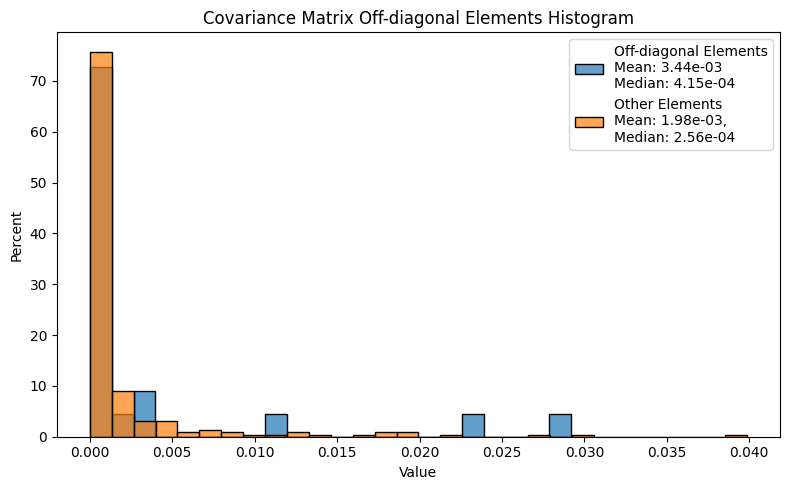

In [53]:
cov_matrix = np.abs(fourier_numpy.iloc[0])
# Extract diagonal, superdiagonal, and subdiagonal elements
def plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=1, return_fig = False, show_fig = True, title= "Covariance Matrix Off-diagonal Elements Histogram"):
    off_diagonal_elements = []
    other_elements = []
    n = cov_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            elif abs(i - j) <= off_diagonal_number:
                off_diagonal_elements.append(cov_matrix[i, j])
            else:
                other_elements.append(cov_matrix[i, j])
# Plot histograms of off-diagonal and other elements
    off_diagonal_mean = "{:.2e}".format(np.mean(off_diagonal_elements))
    other_mean = "{:.2e}".format(np.mean(other_elements))
    off_diagonal_median = "{:.2e}".format(np.median(off_diagonal_elements))
    other_median = "{:.2e}".format(np.median(other_elements))
    
    fig, ax = plt.subplots(figsize=(8, 5))

    # Calculate binwidth as 1/30th of the data range (off-diagonal + other elements)
    all_elements = np.array(off_diagonal_elements + other_elements)
    data_range = np.max(all_elements) - np.min(all_elements)
    binwidth = data_range / 30 if data_range > 0 else 0.001

    sns.histplot(off_diagonal_elements, binwidth=binwidth, color='tab:blue', alpha=0.7, stat='percent', label=f'Off-diagonal Elements\nMean: {off_diagonal_mean}  \nMedian: {off_diagonal_median}', ax=ax)
    sns.histplot(other_elements, binwidth=binwidth, color='tab:orange', alpha=0.7, stat='percent', label=f'Other Elements\nMean: {other_mean}, \nMedian: {other_median}', ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Percent')
    ax.legend()

    plt.tight_layout()
    if show_fig:
        plt.show()
    if return_fig:
        return fig, axes
plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=1)

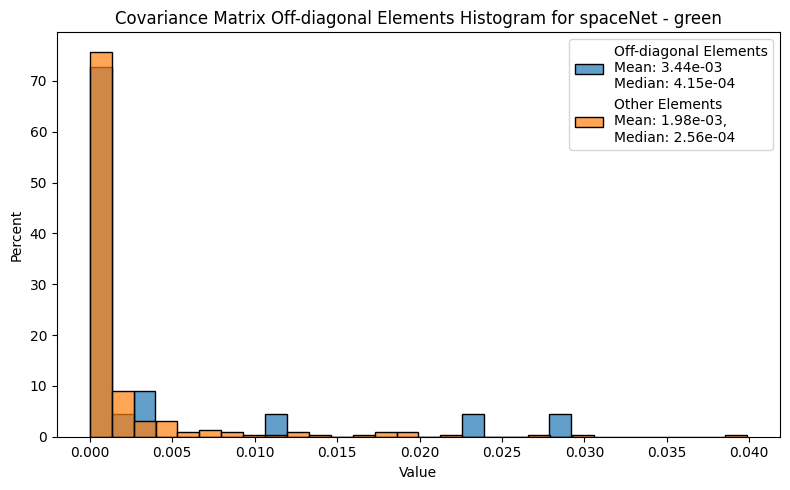

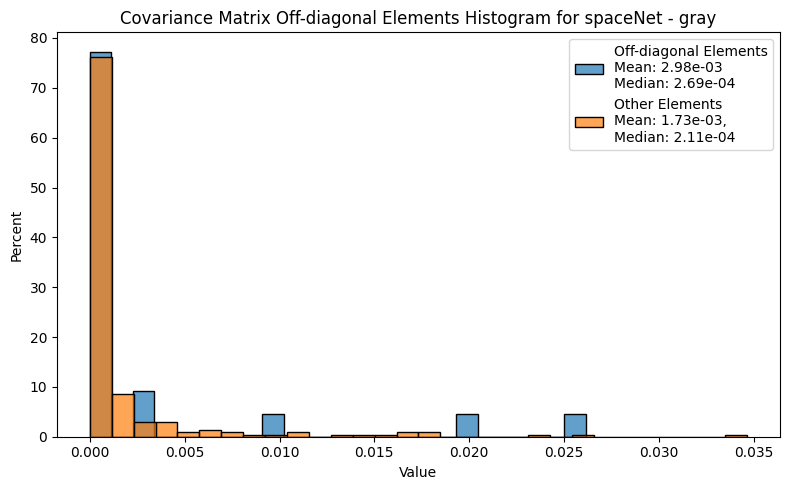

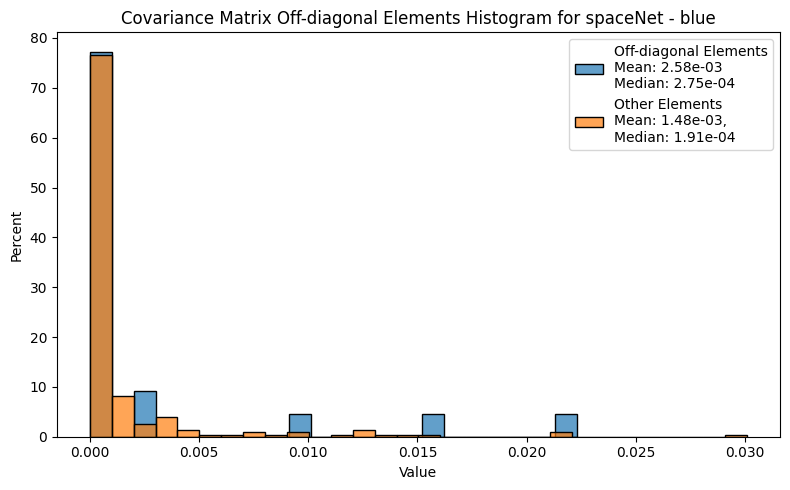

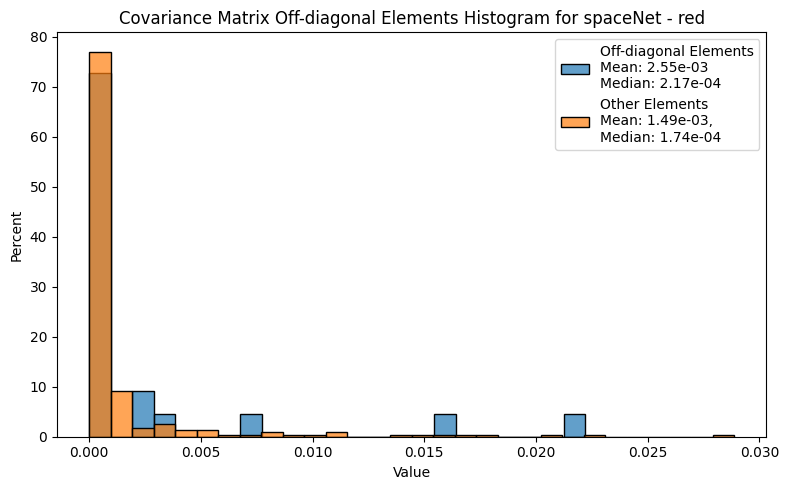

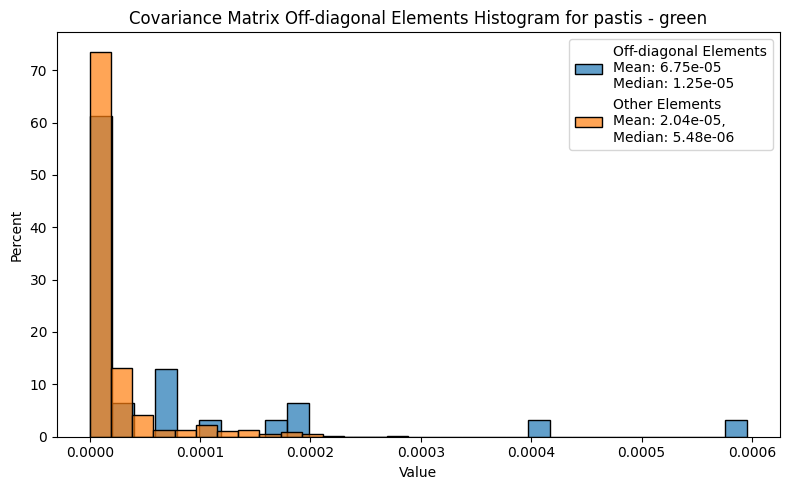

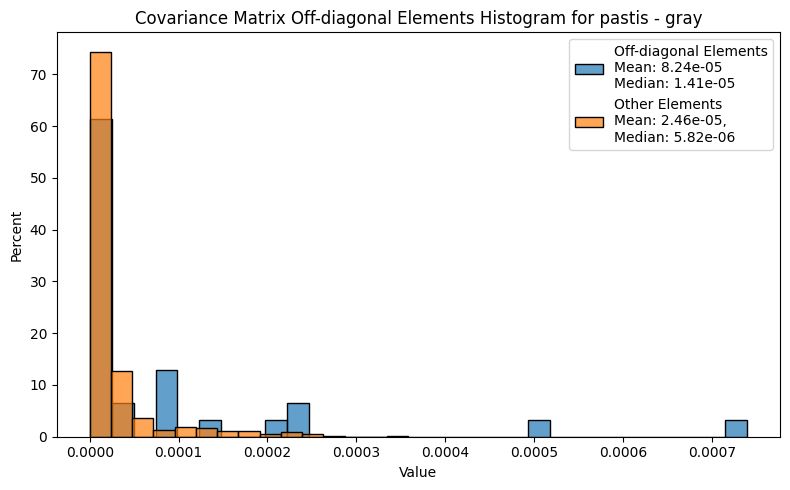

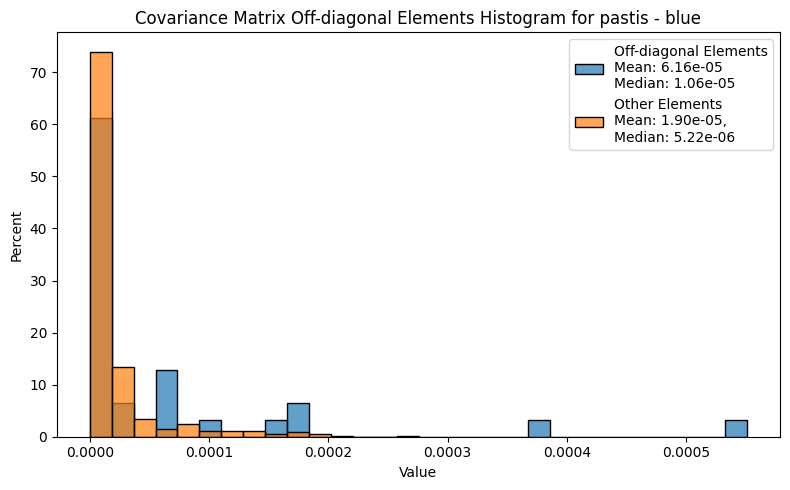

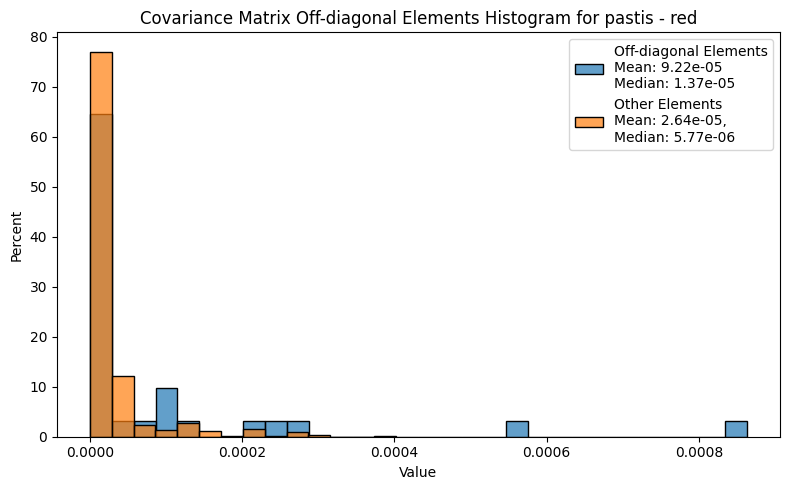

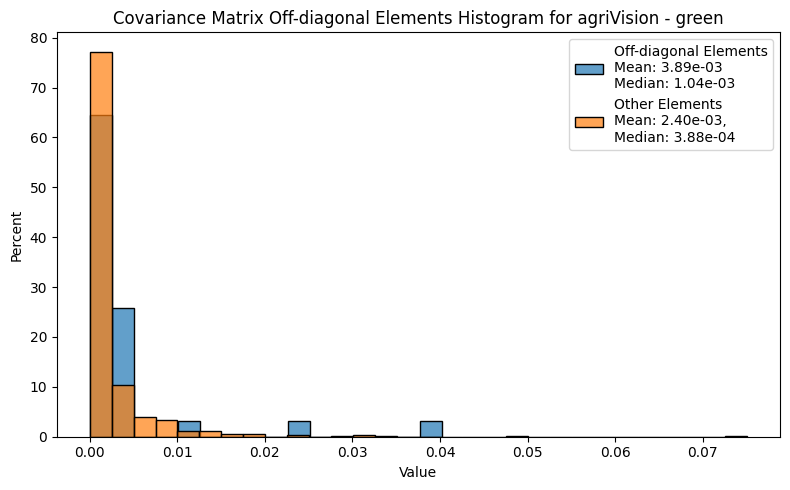

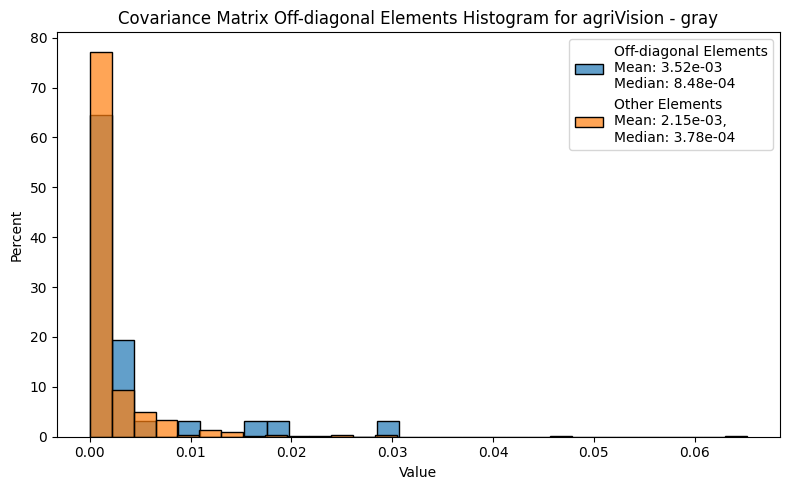

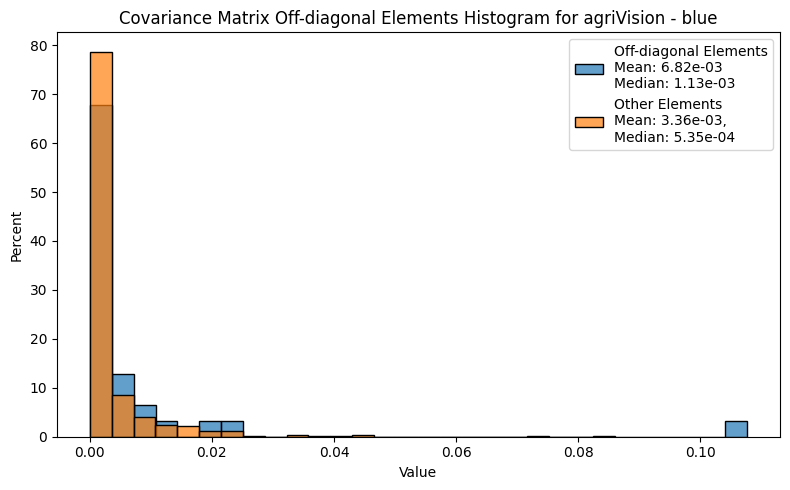

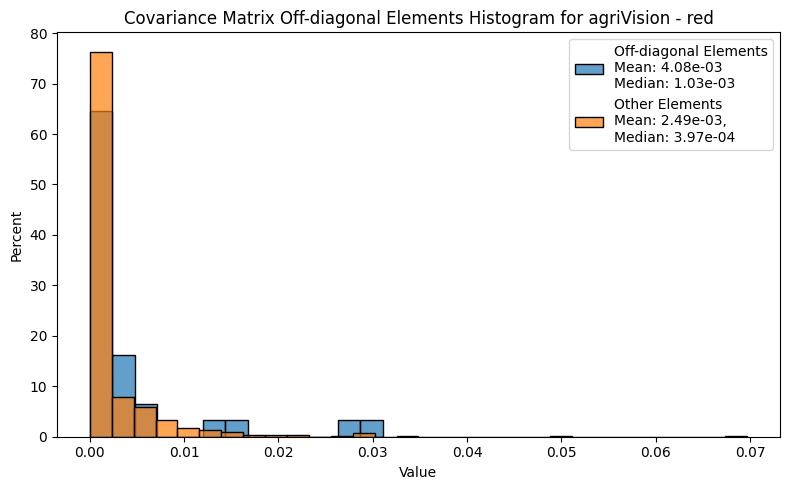

In [54]:
for row in fourier_df.iterrows():
    cov_matrix = np.abs(row[1]["cov_matrix"])
    dataset = row[1]["dataset"]
    channel = row[1]["channel"]

    title = f"Covariance Matrix Off-diagonal Elements Histogram for {dataset} - {channel}"
    plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=1, title=title)

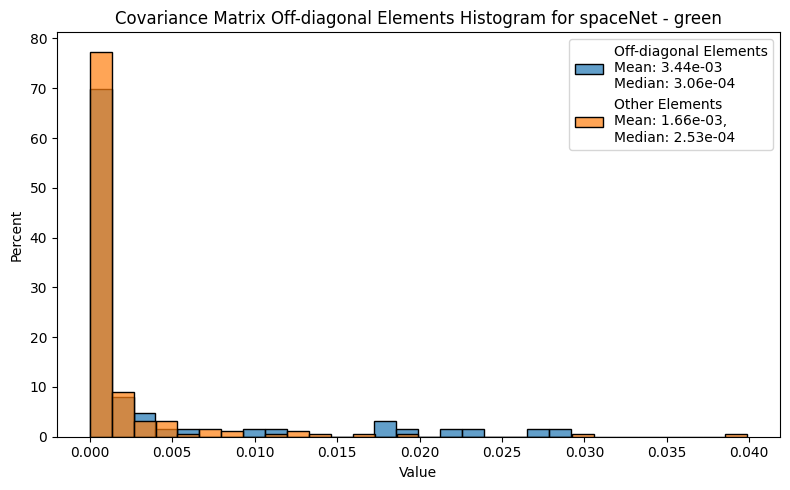

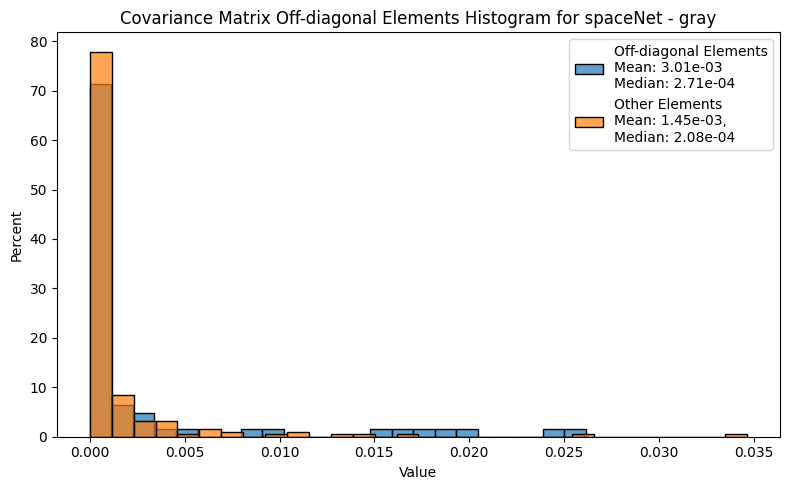

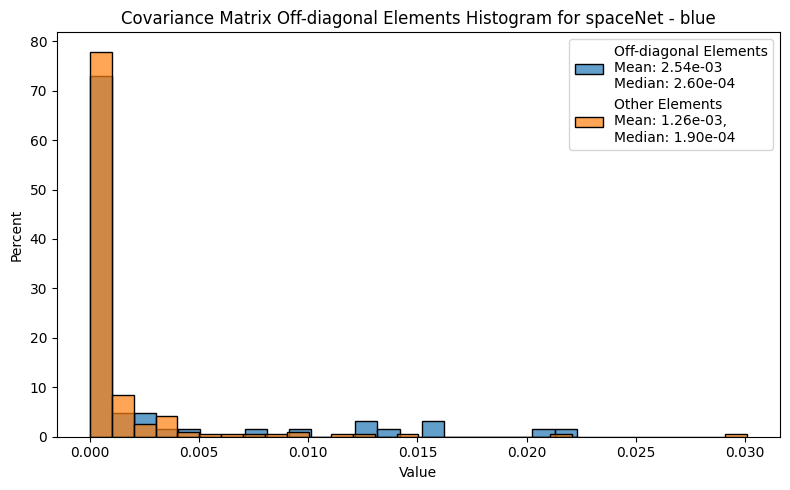

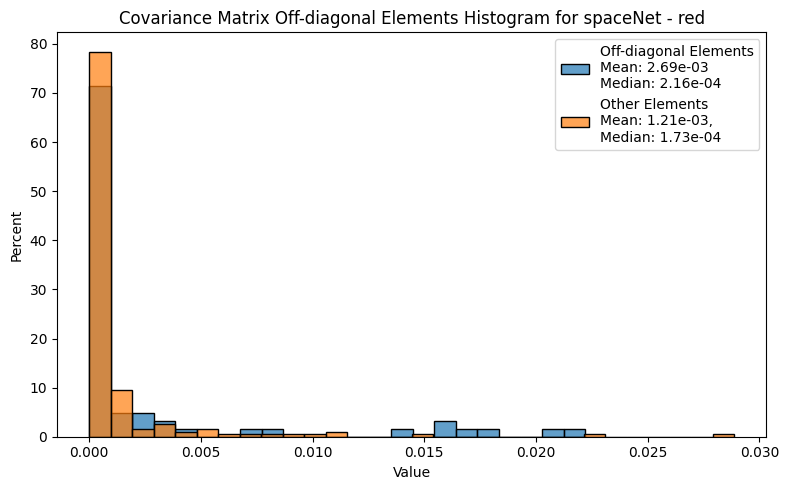

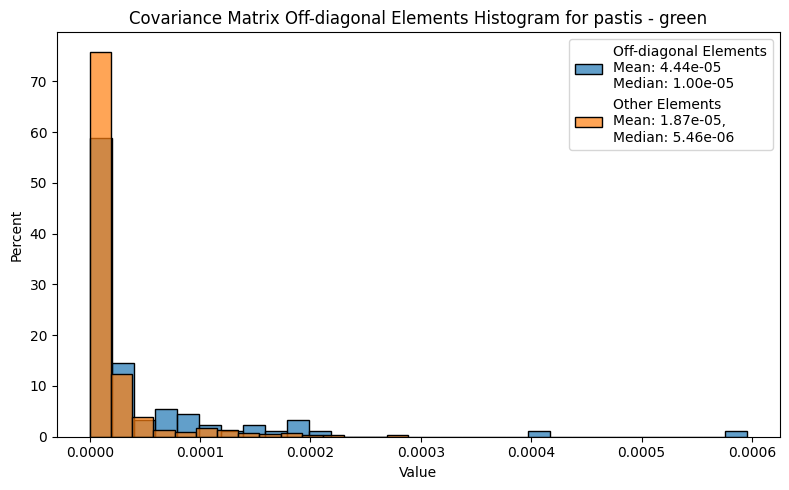

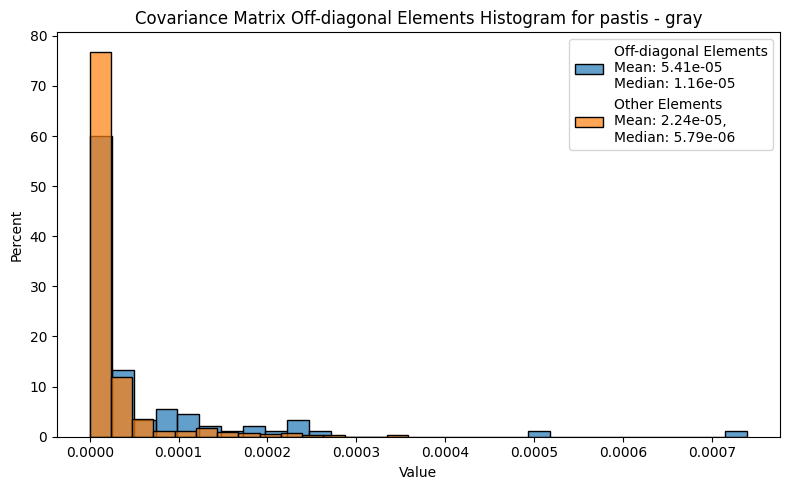

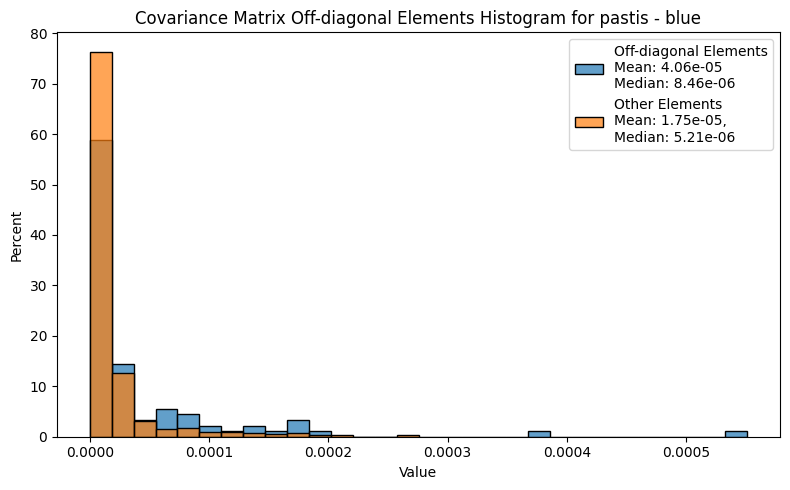

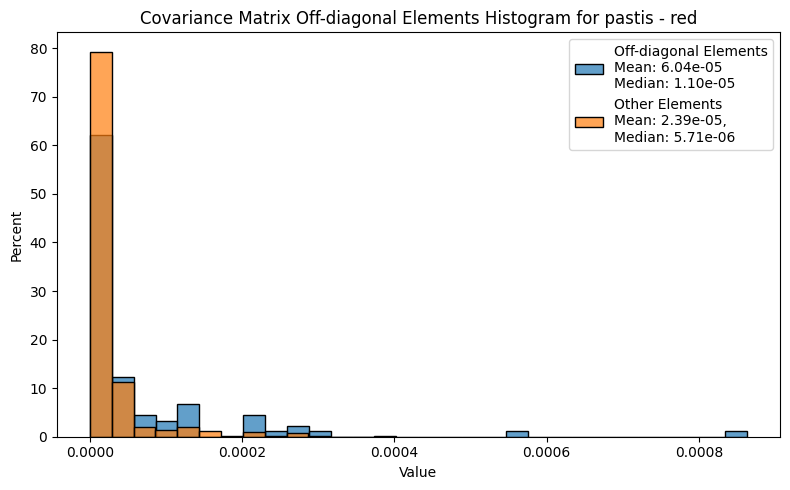

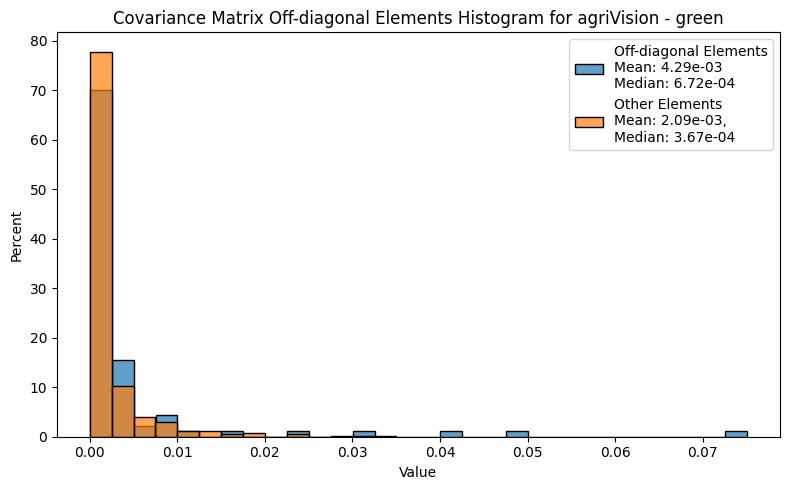

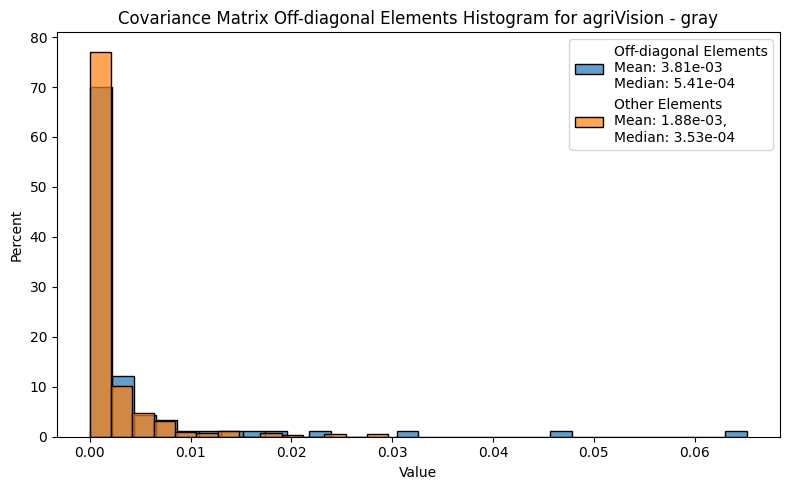

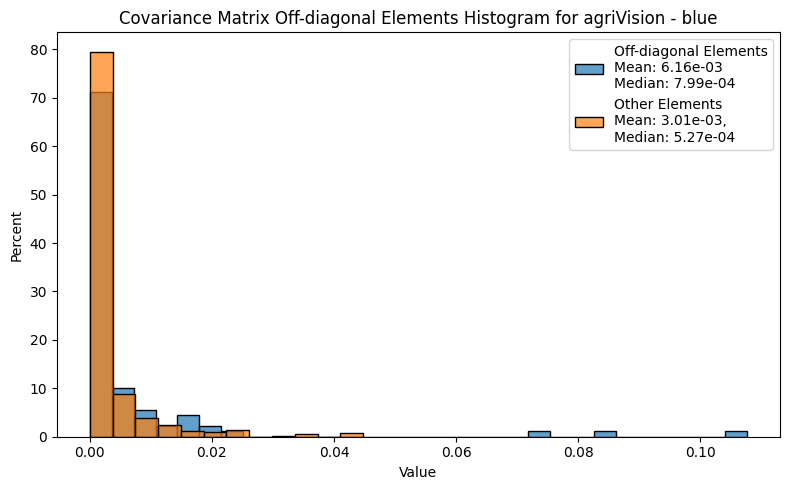

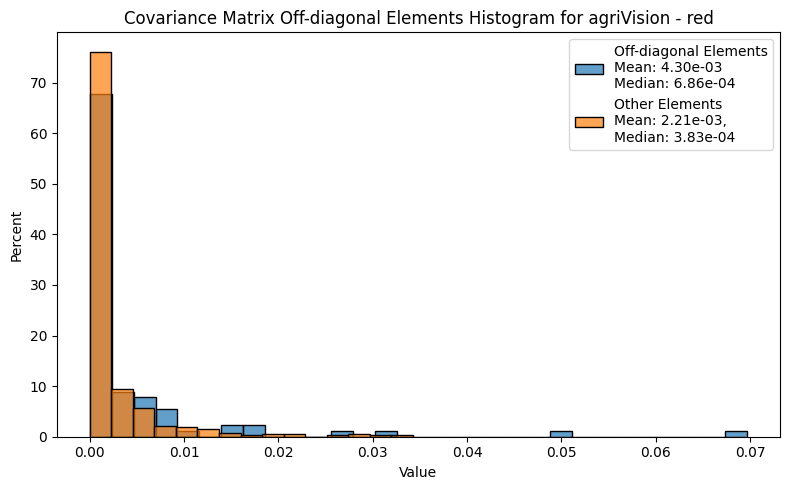

In [55]:
for row in fourier_df.iterrows():
    cov_matrix = np.abs(row[1]["cov_matrix"])
    dataset = row[1]["dataset"]
    channel = row[1]["channel"]

    title = f"Covariance Matrix Off-diagonal Elements Histogram for {dataset} - {channel}"
    plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=3, title=title)

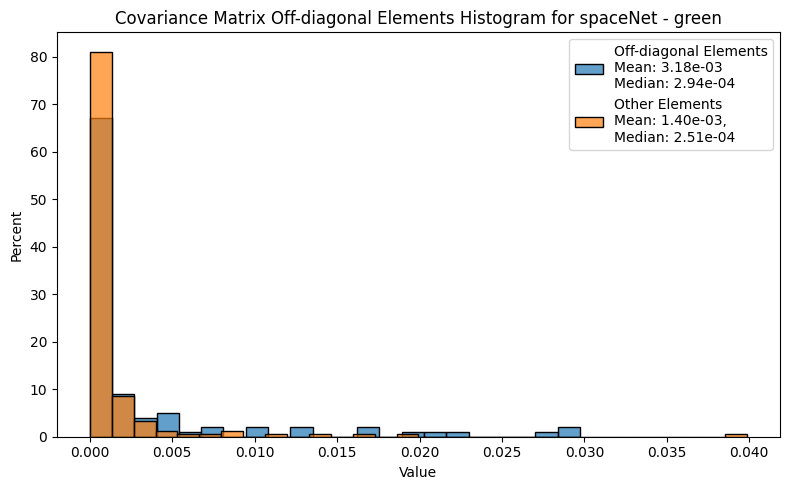

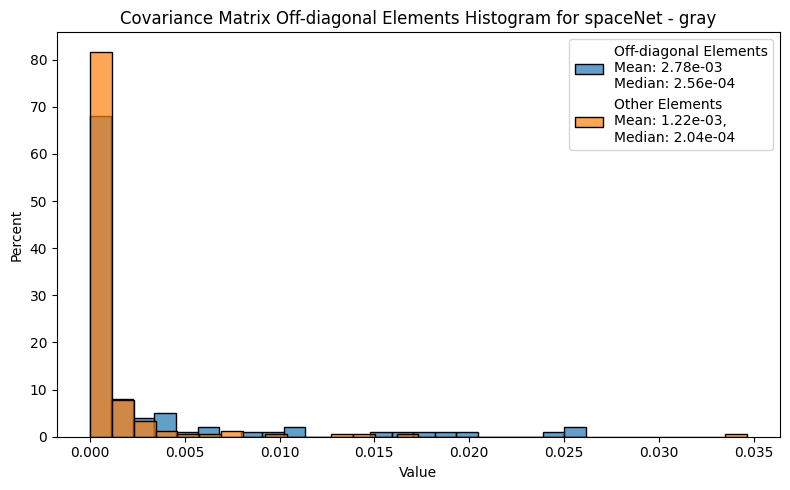

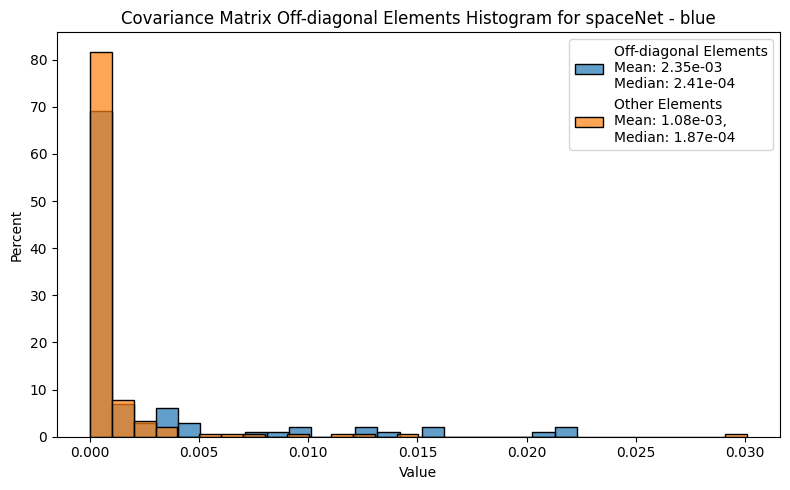

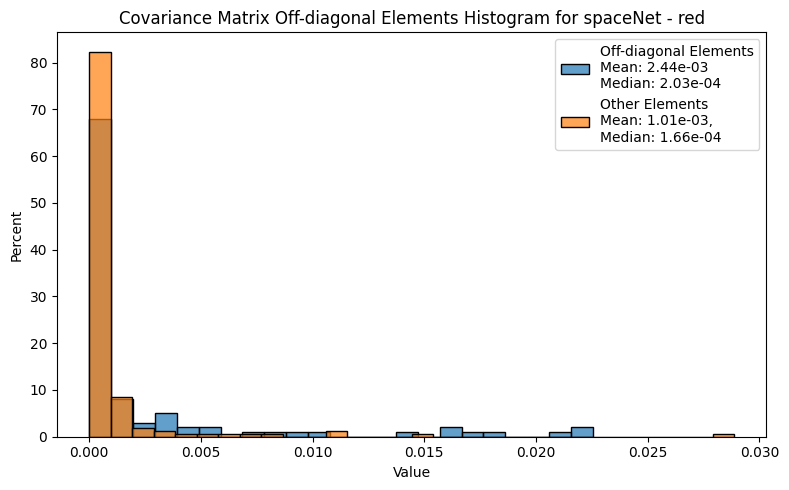

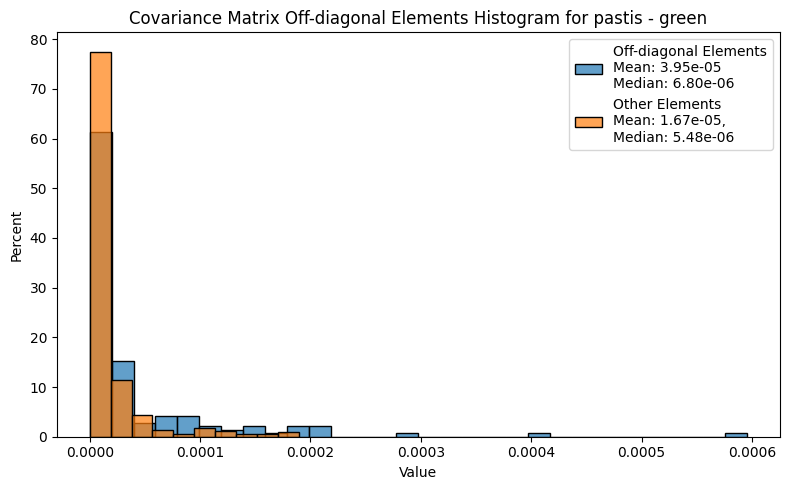

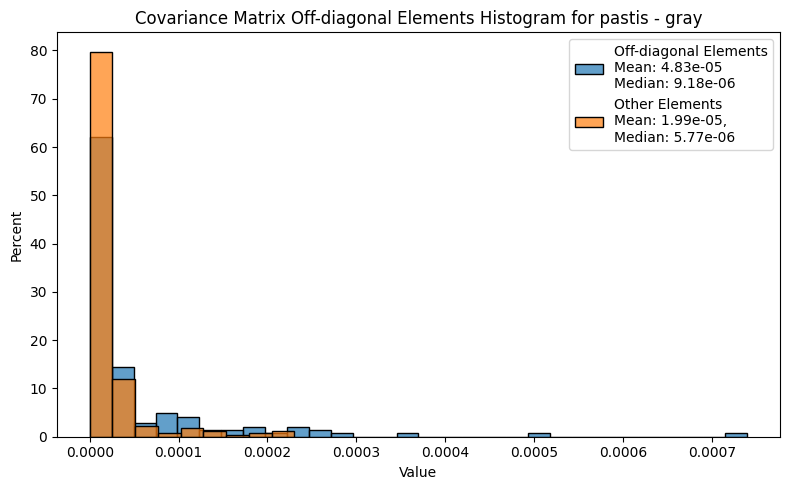

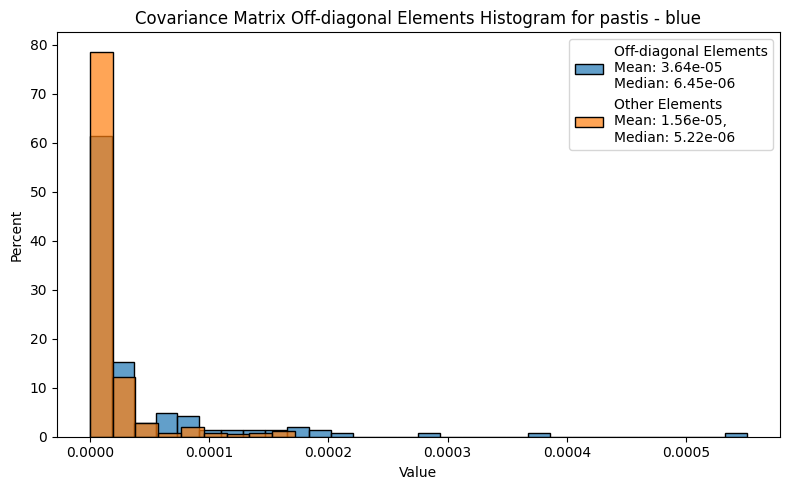

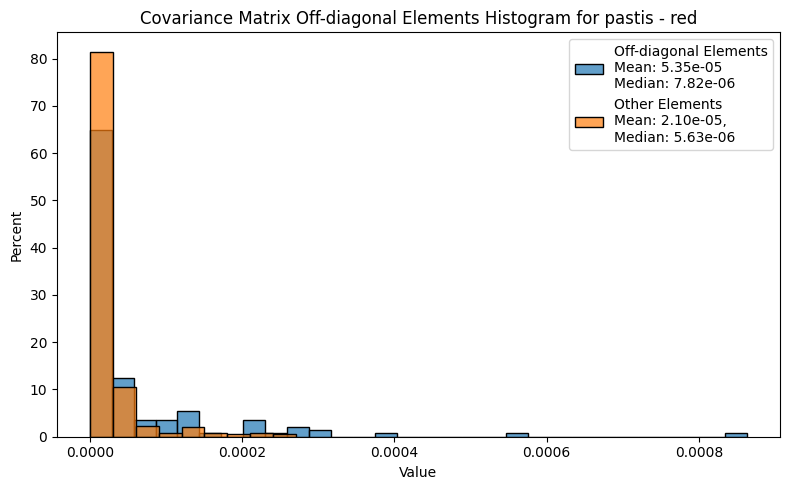

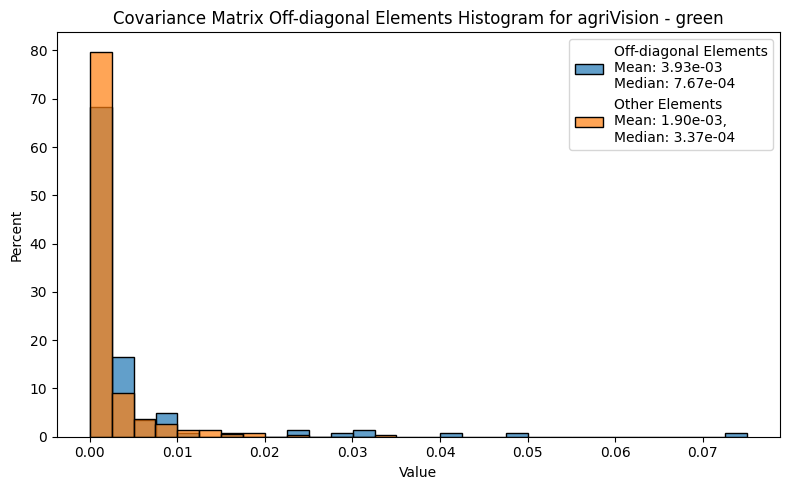

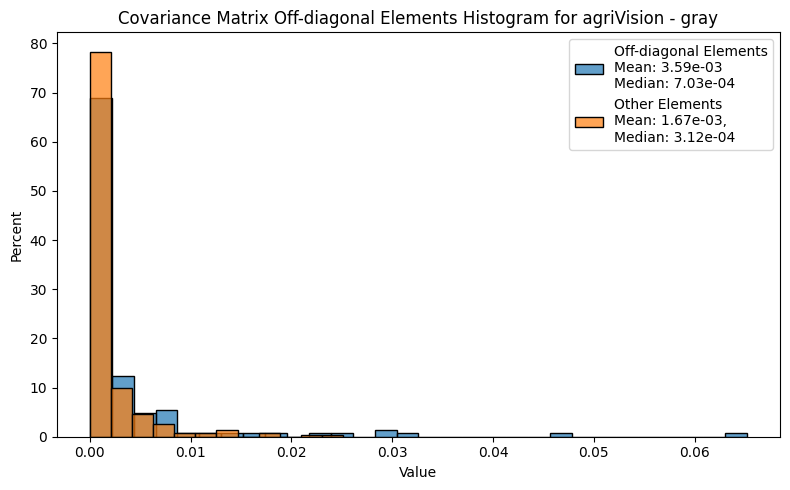

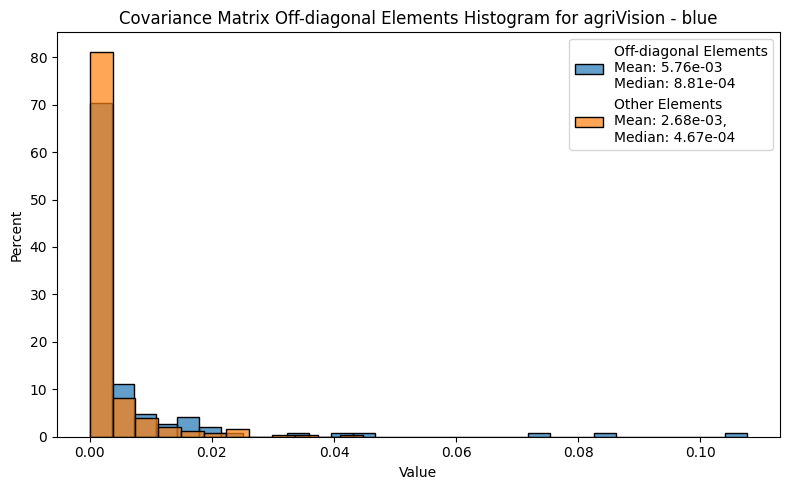

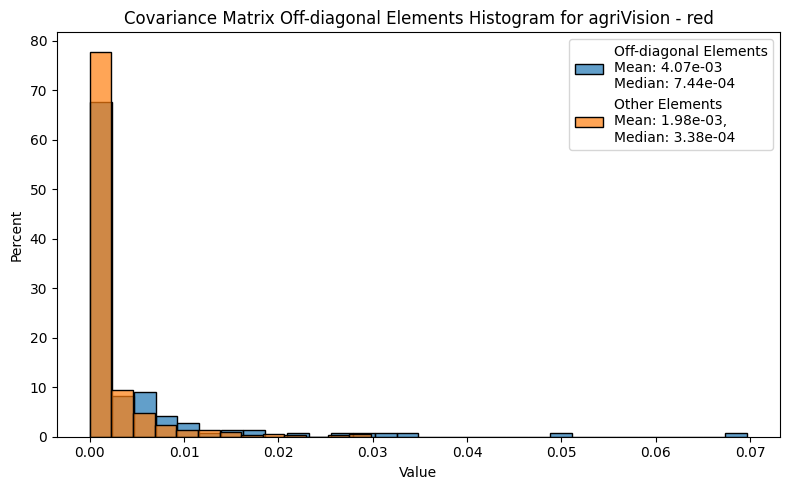

In [56]:
for row in fourier_df.iterrows():
    cov_matrix = np.abs(row[1]["cov_matrix"])
    dataset = row[1]["dataset"]
    channel = row[1]["channel"]

    title = f"Covariance Matrix Off-diagonal Elements Histogram for {dataset} - {channel}"
    plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=5, title=title)

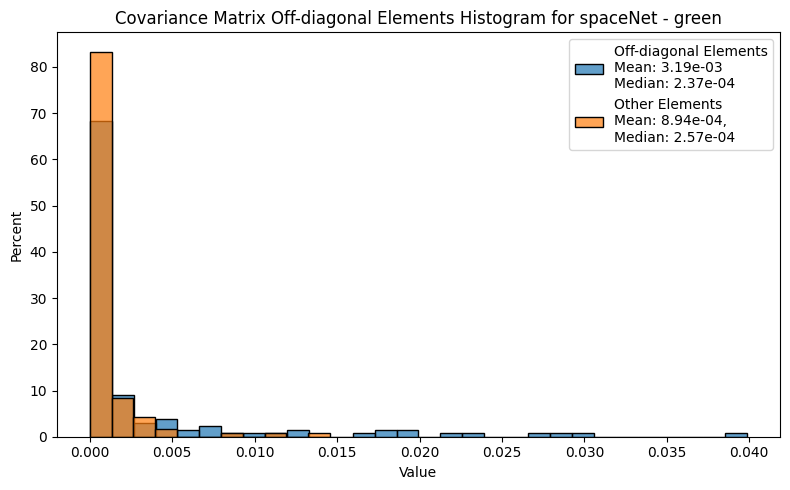

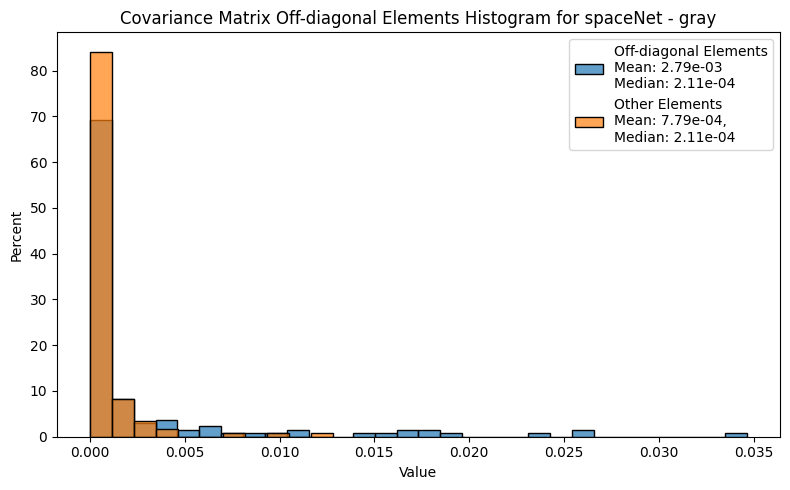

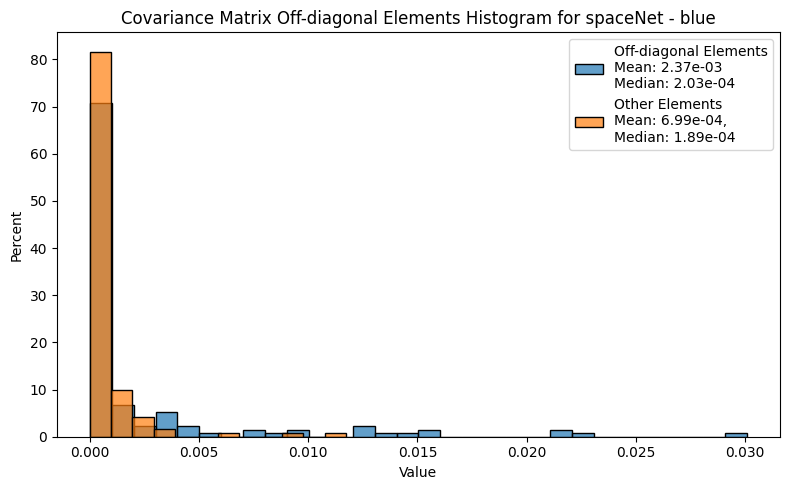

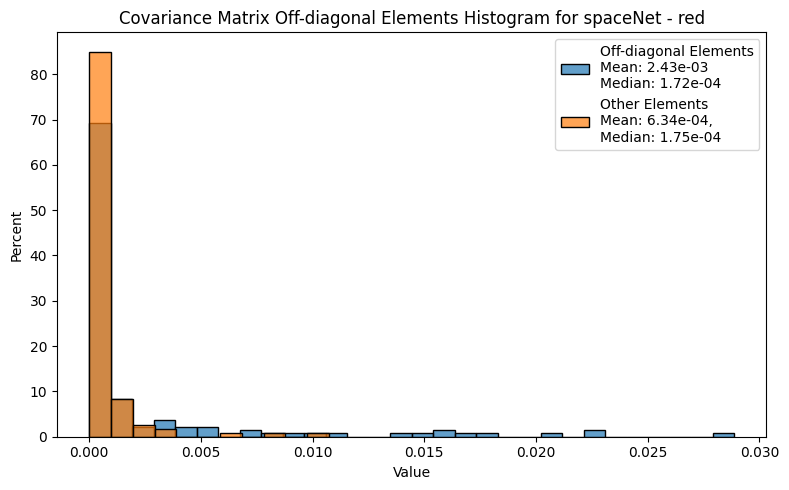

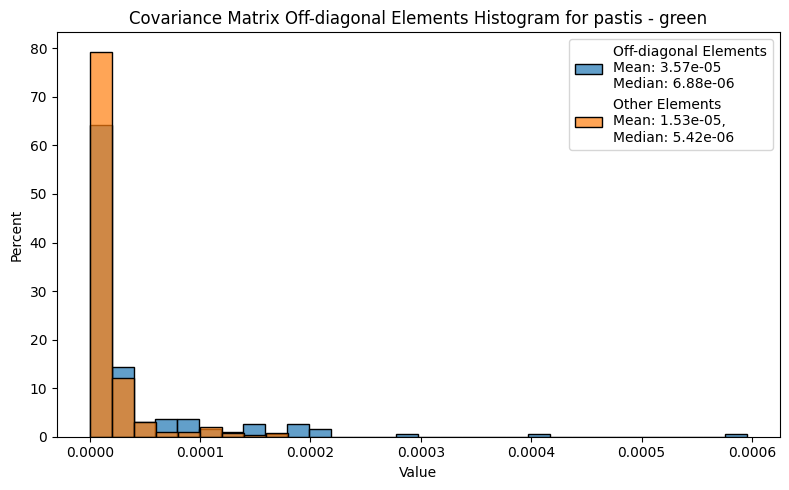

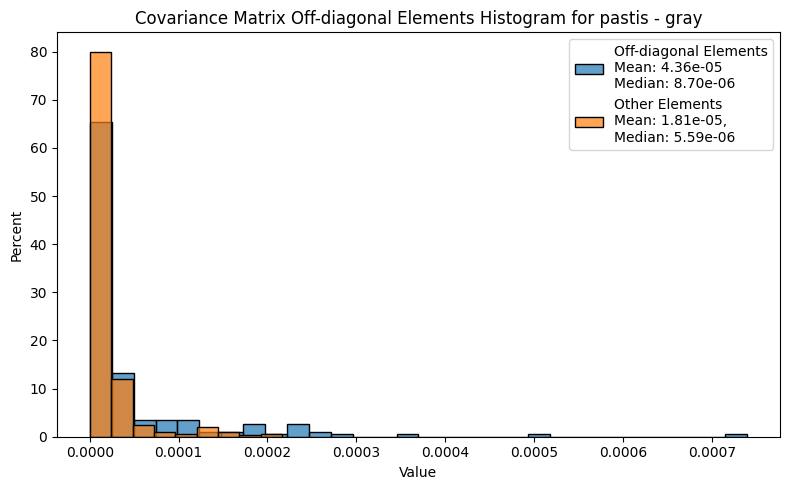

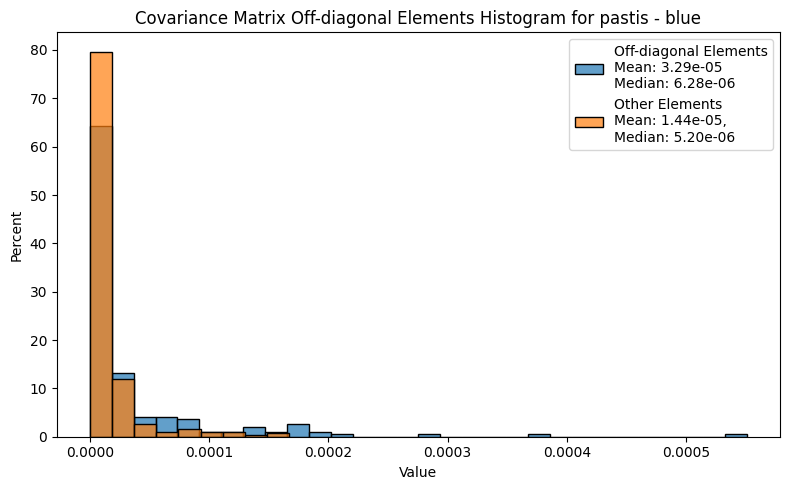

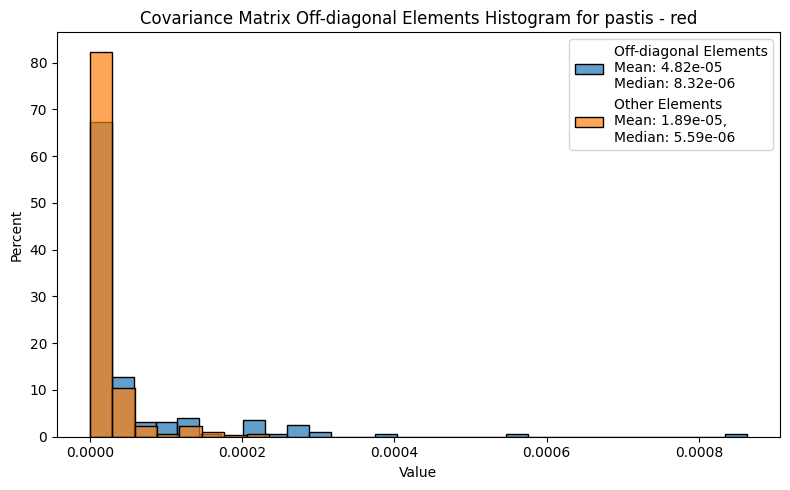

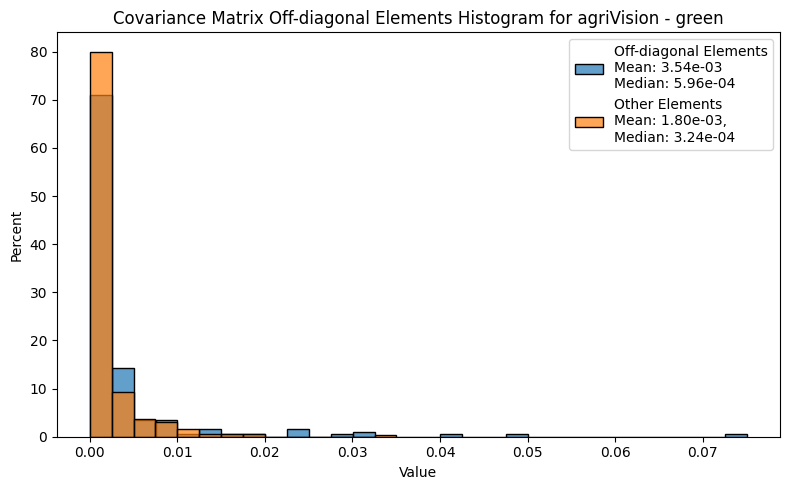

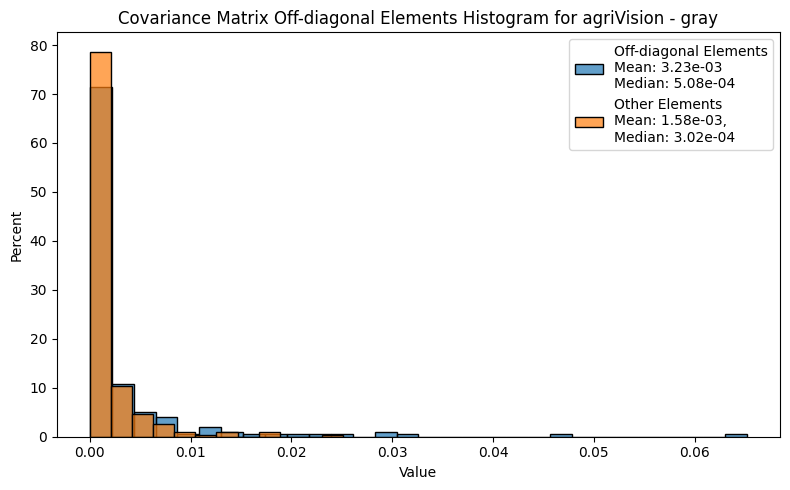

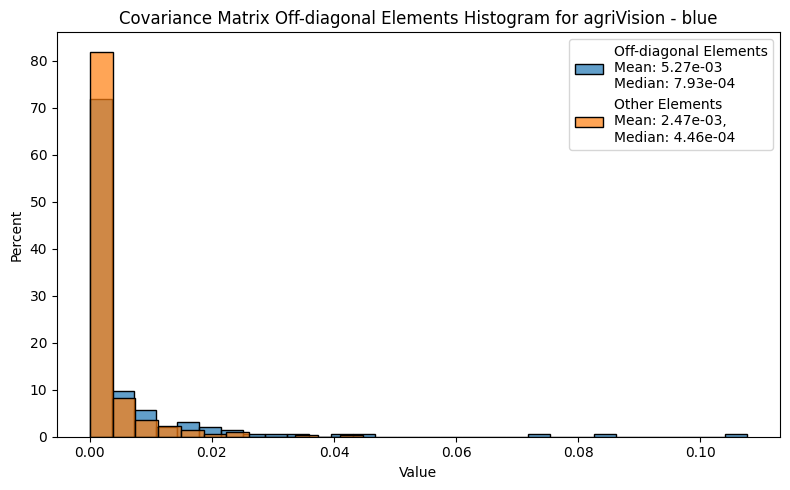

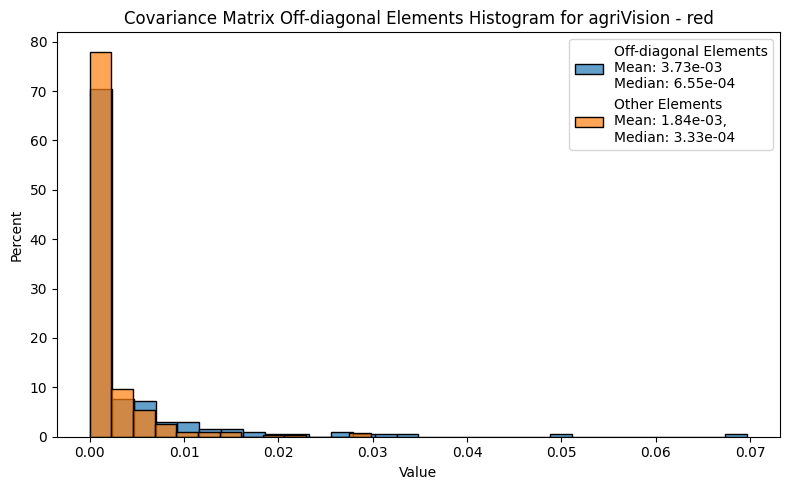

In [57]:
for row in fourier_df.iterrows():
    cov_matrix = np.abs(row[1]["cov_matrix"])
    dataset = row[1]["dataset"]
    channel = row[1]["channel"]

    title = f"Covariance Matrix Off-diagonal Elements Histogram for {dataset} - {channel}"
    plot_off_diagonal_histograms(cov_matrix, off_diagonal_number=7, title=title)

# Covariance Matrix Visualization

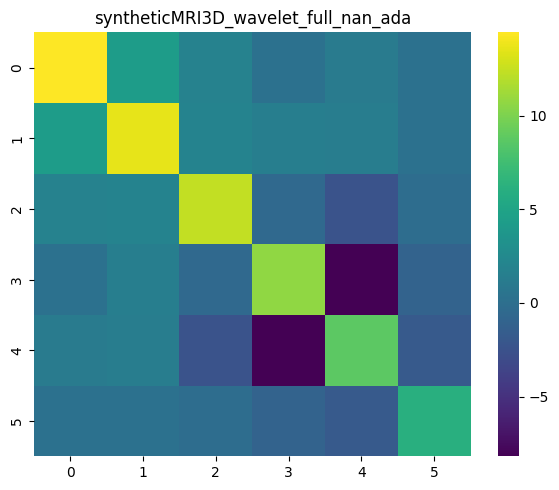

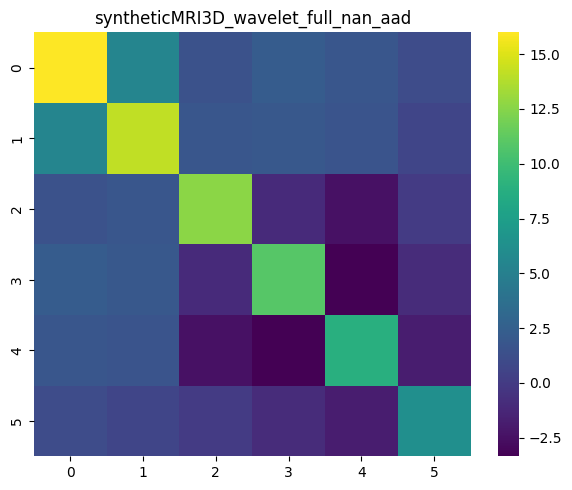

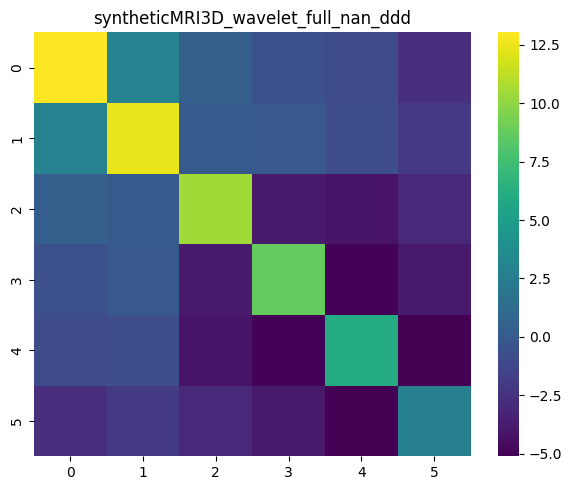

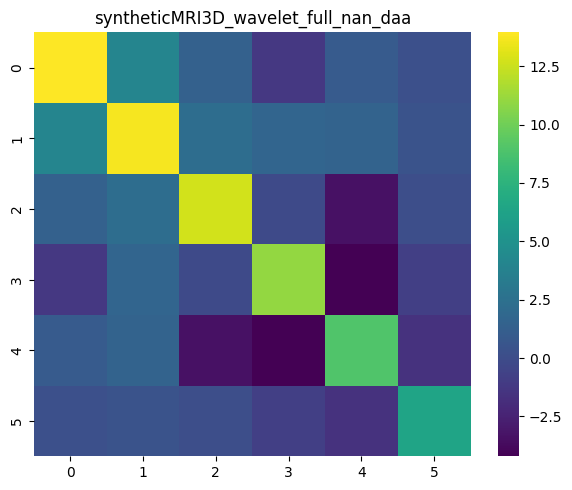

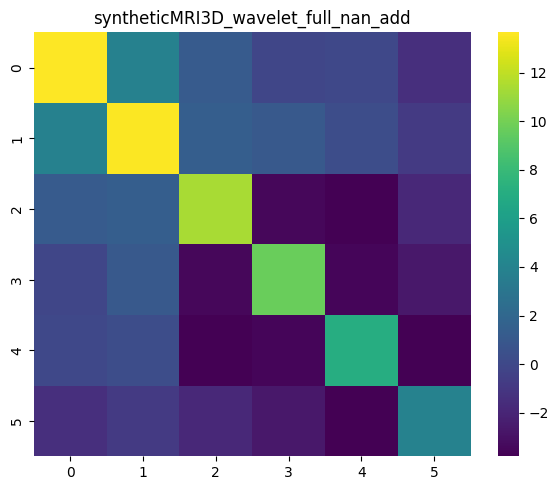

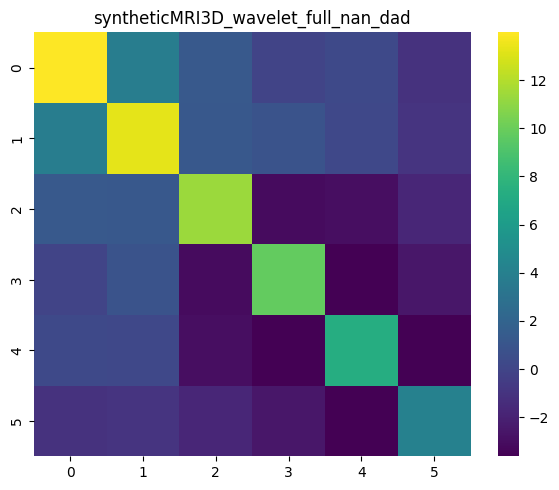

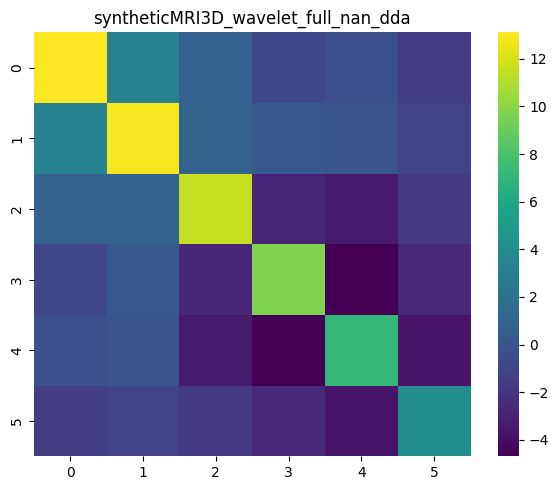

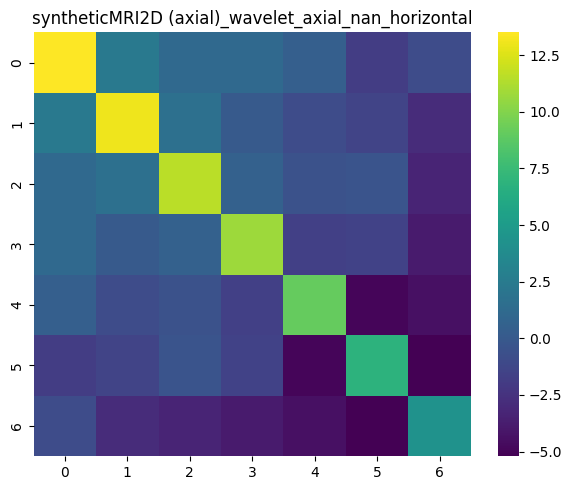

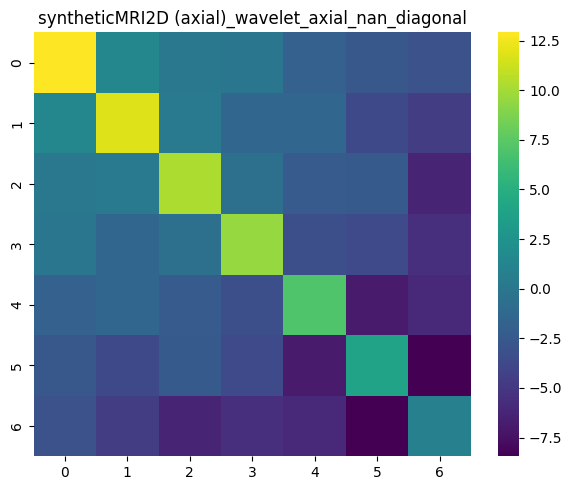

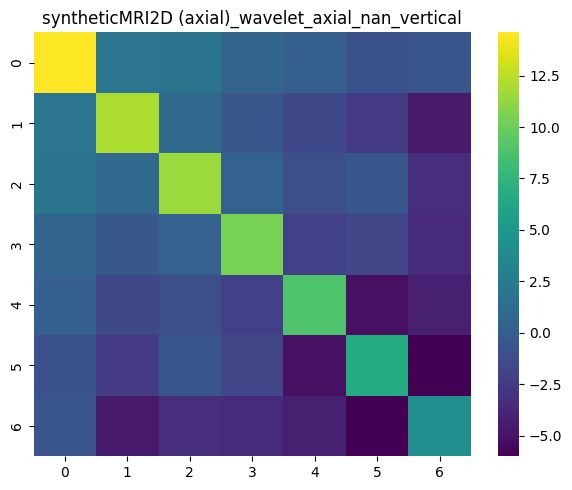

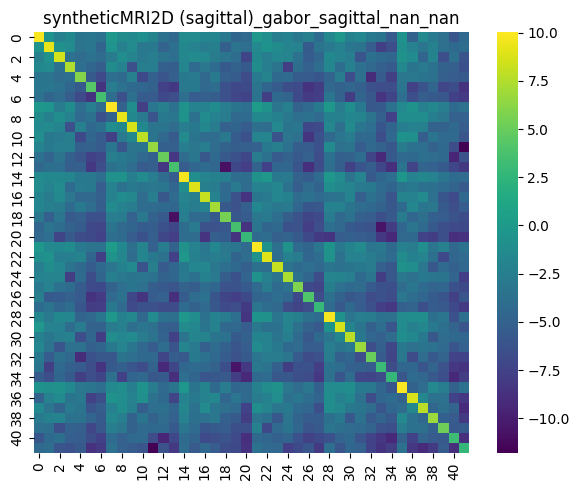

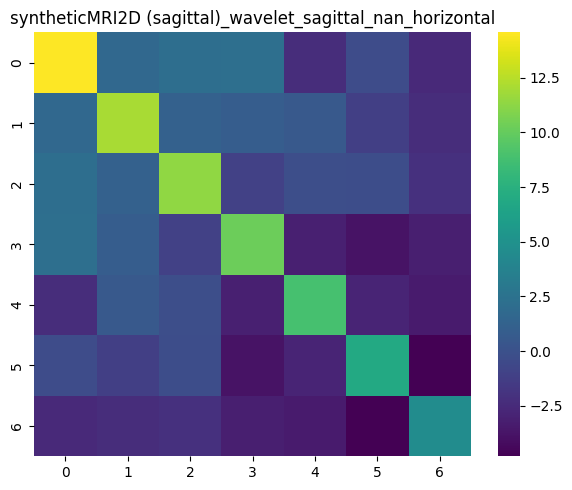

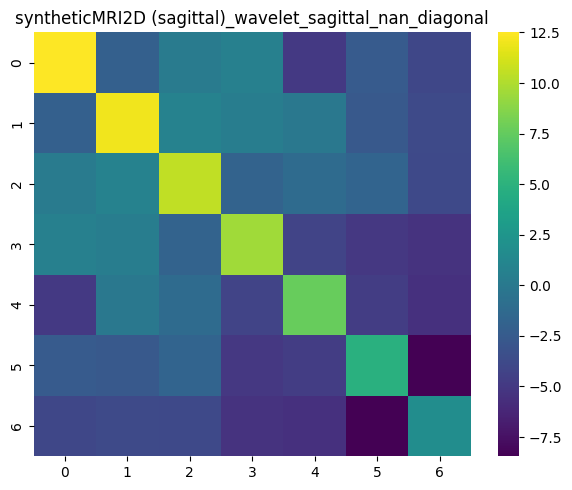

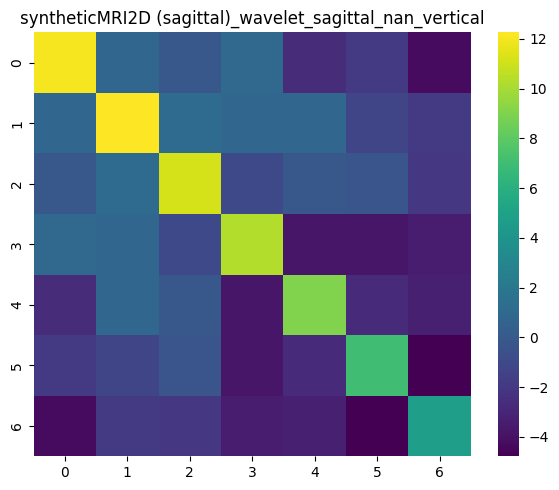

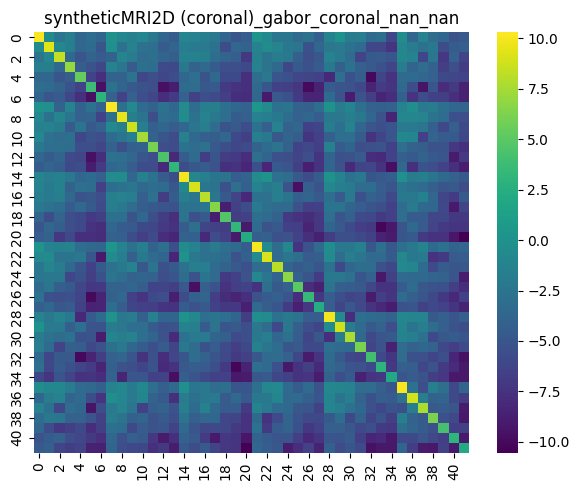

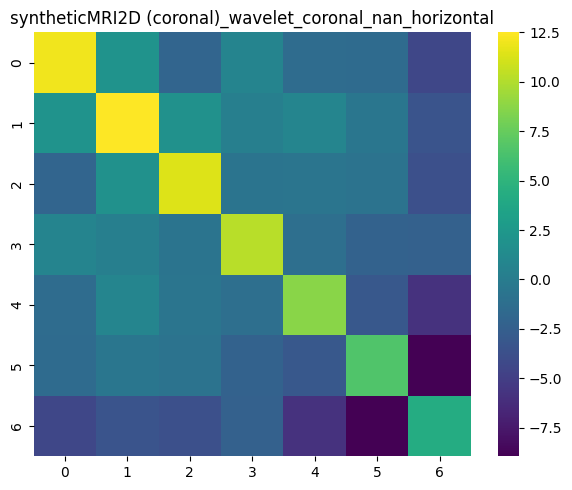

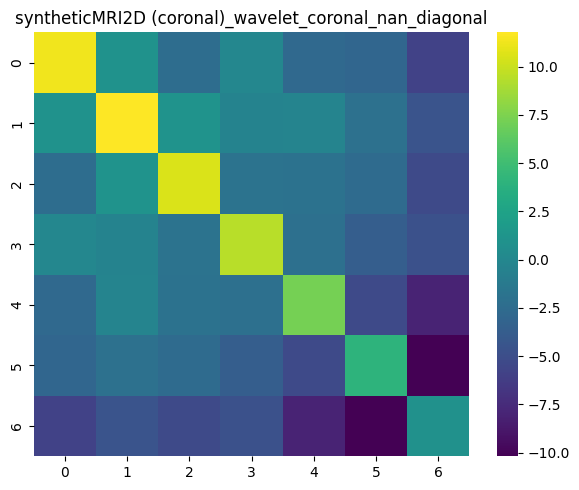

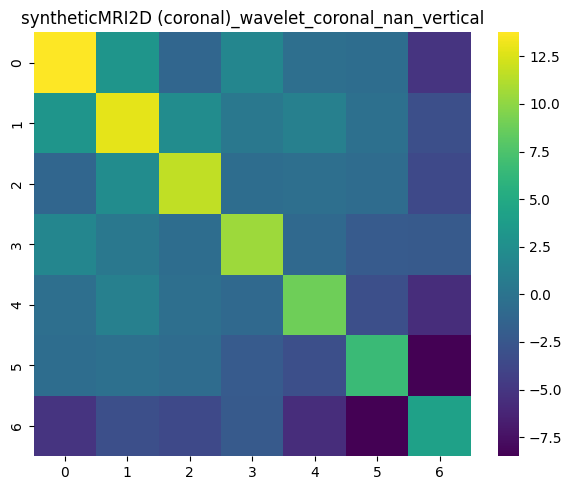

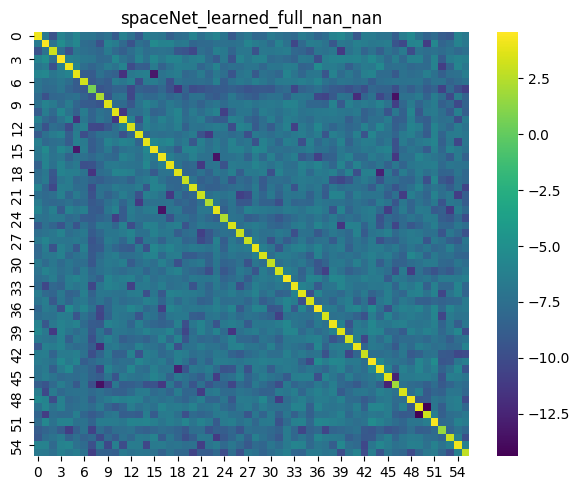

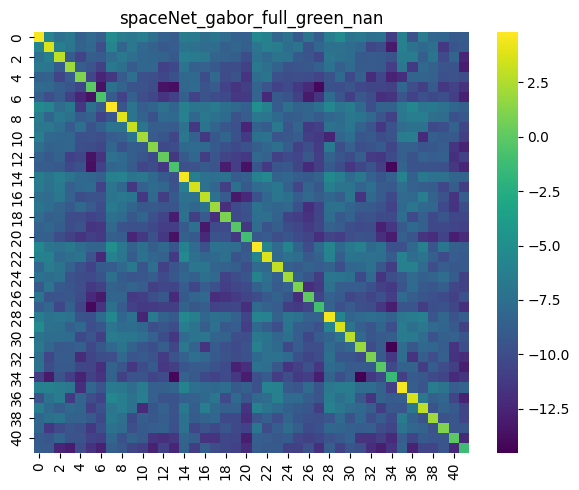

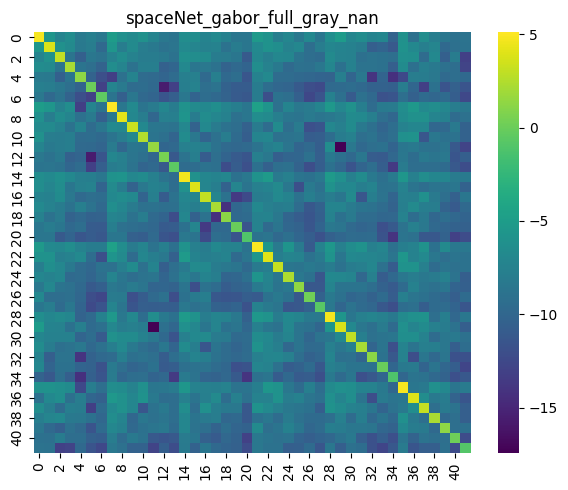

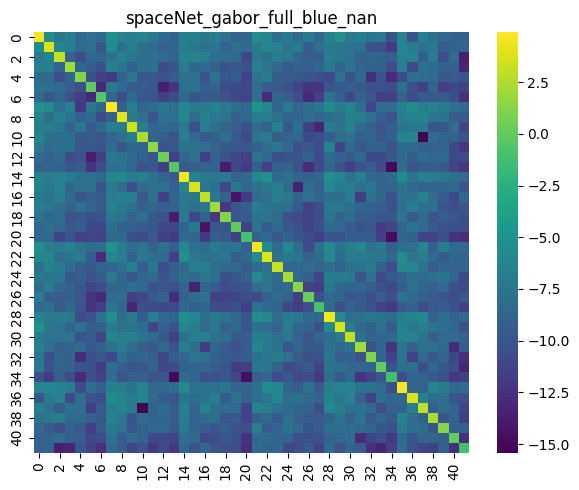

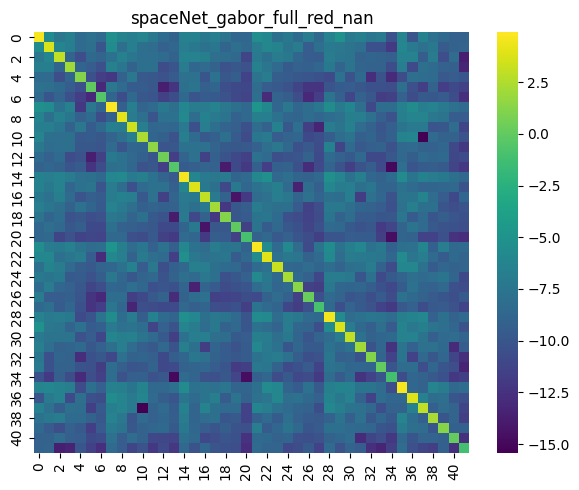

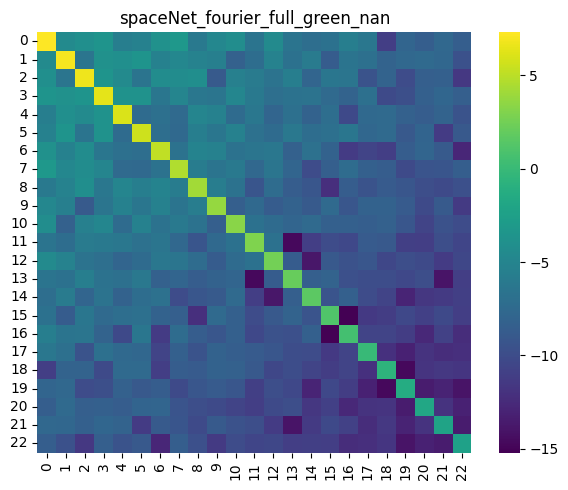

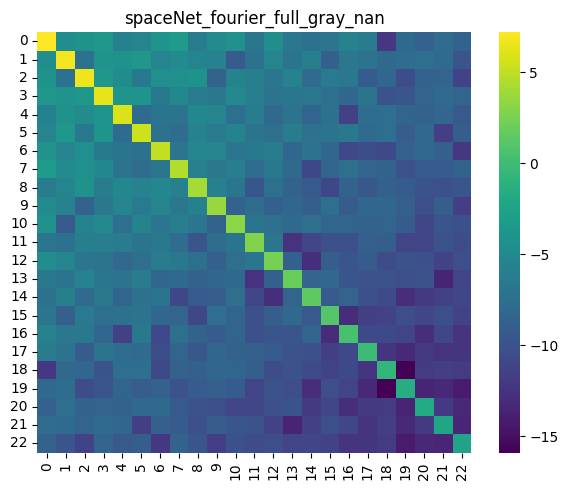

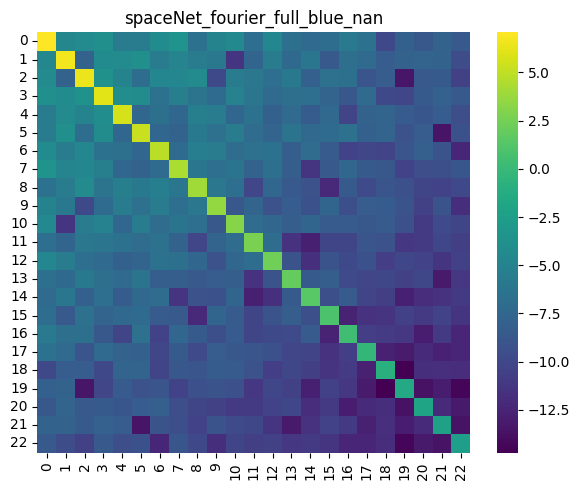

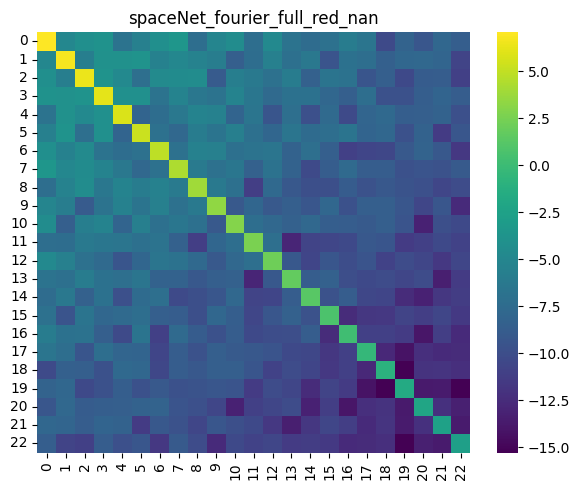

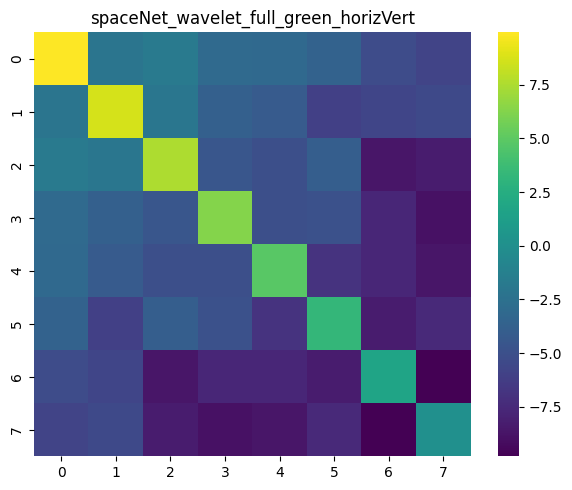

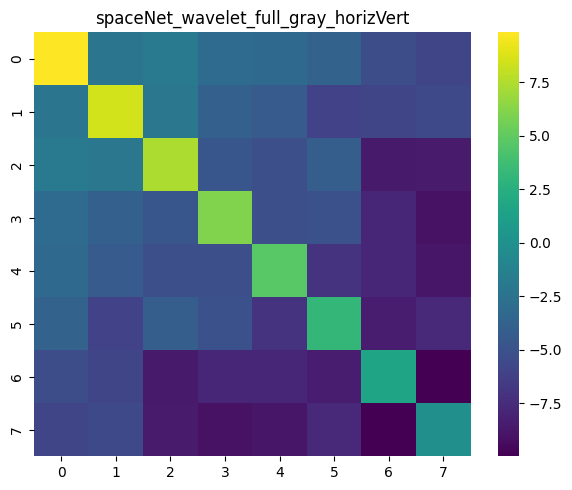

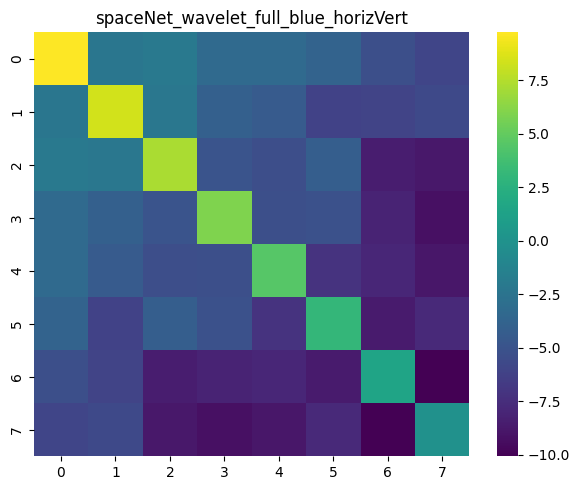

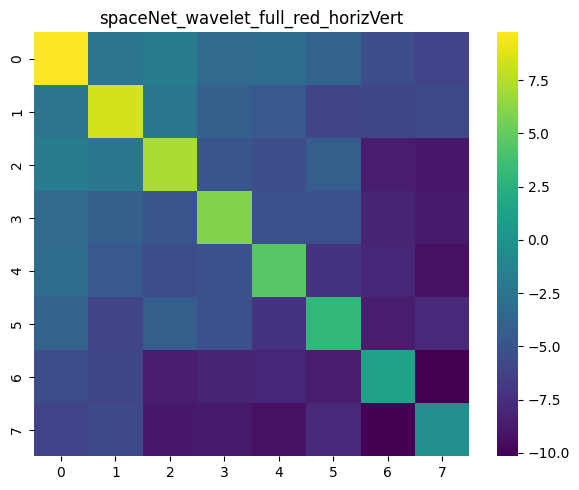

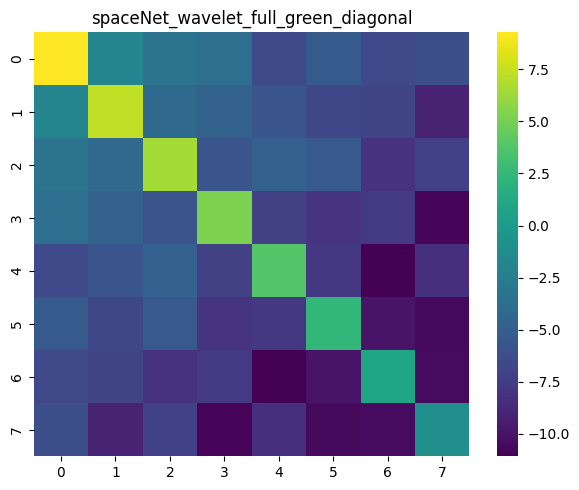

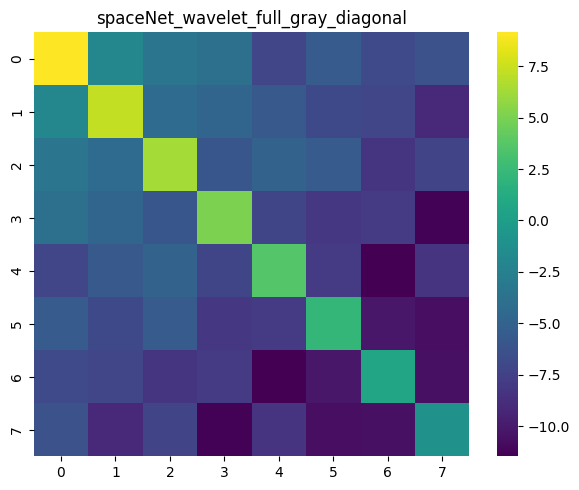

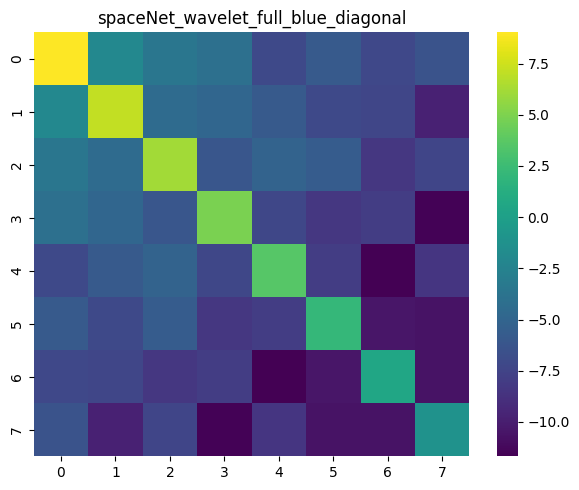

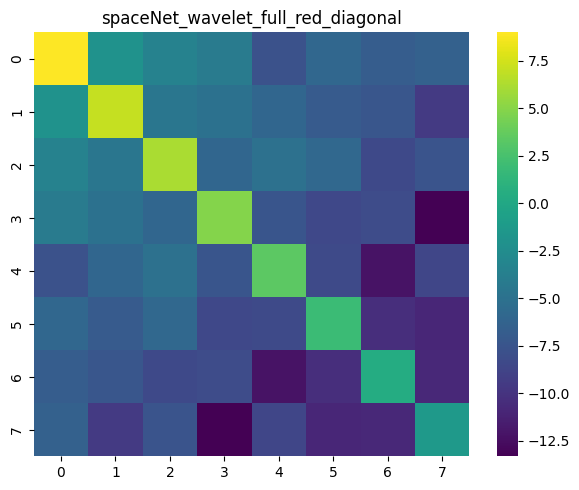

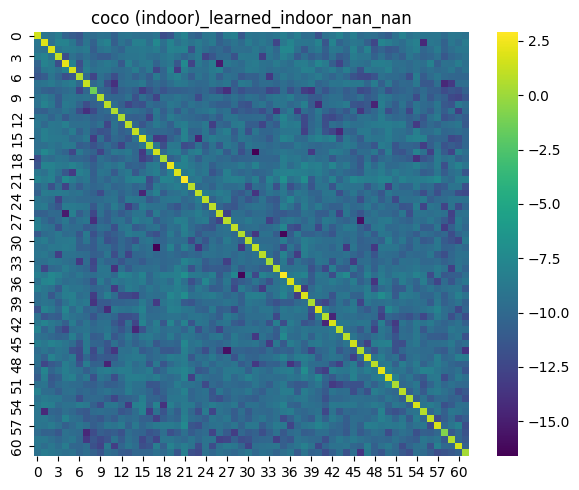

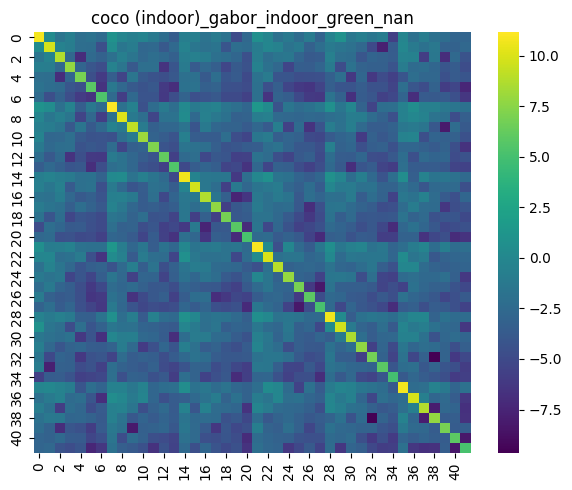

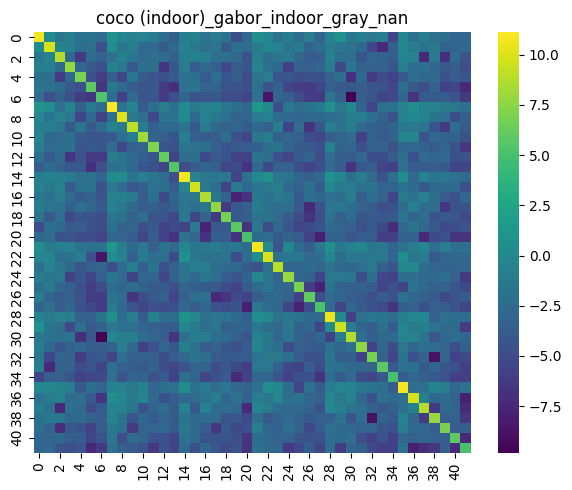

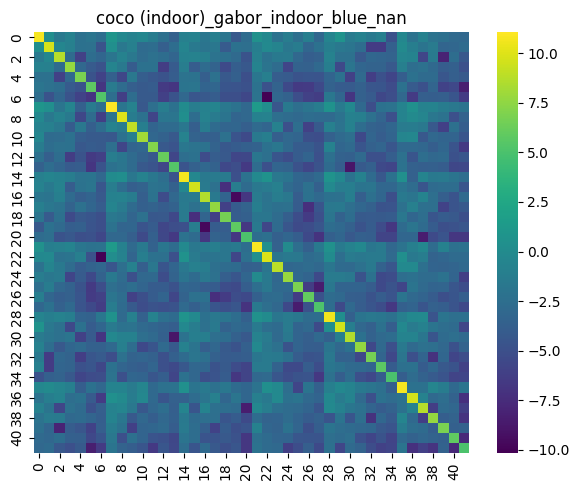

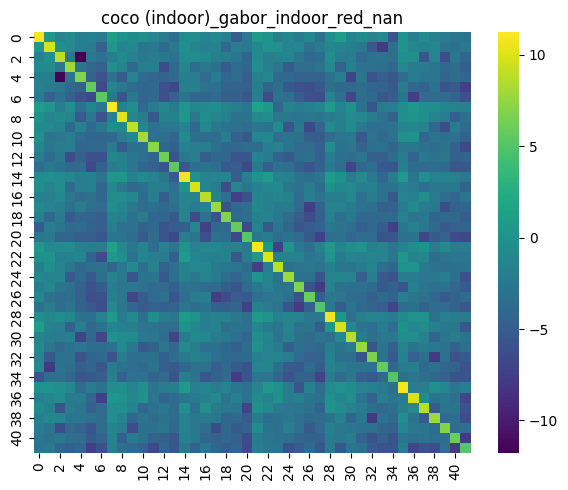

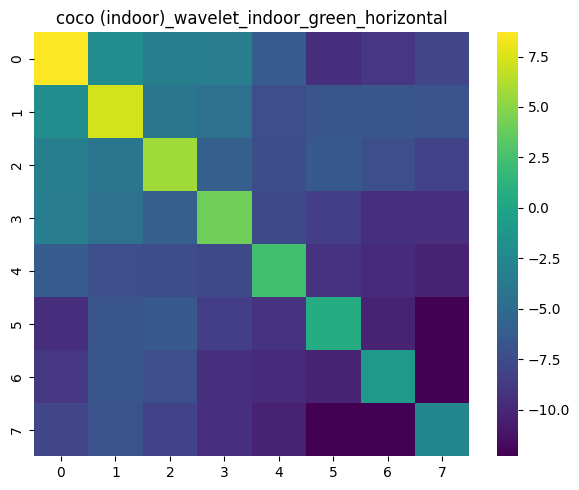

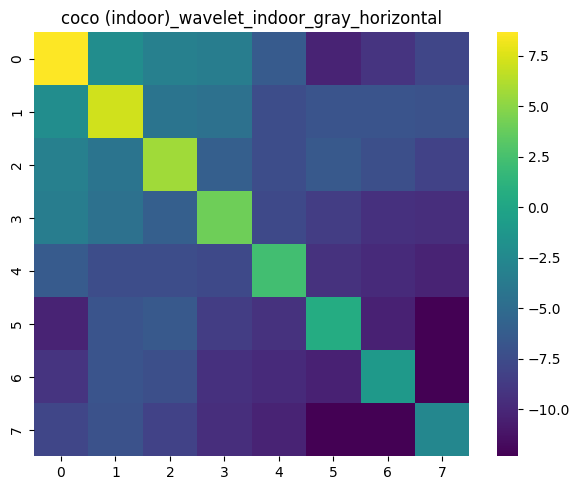

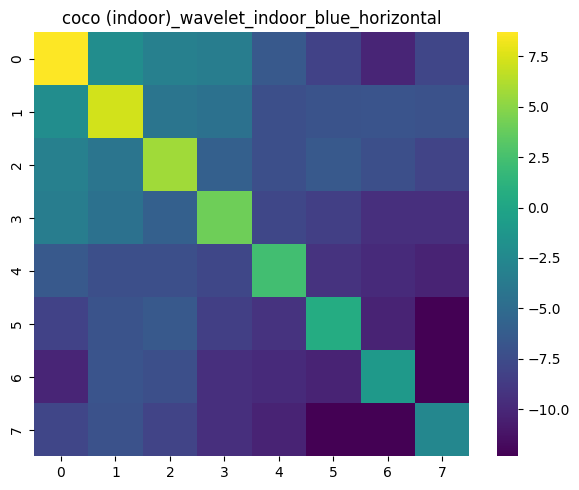

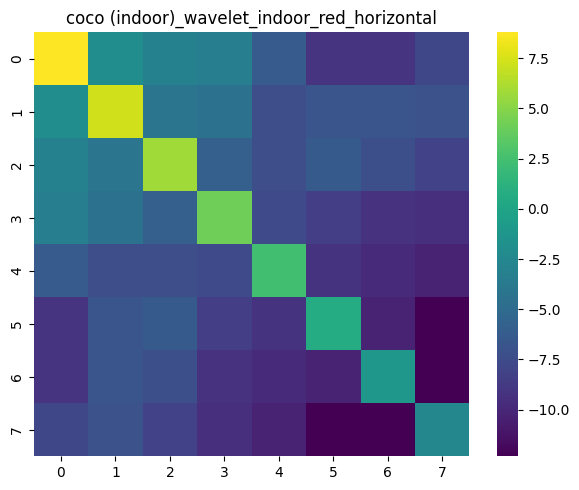

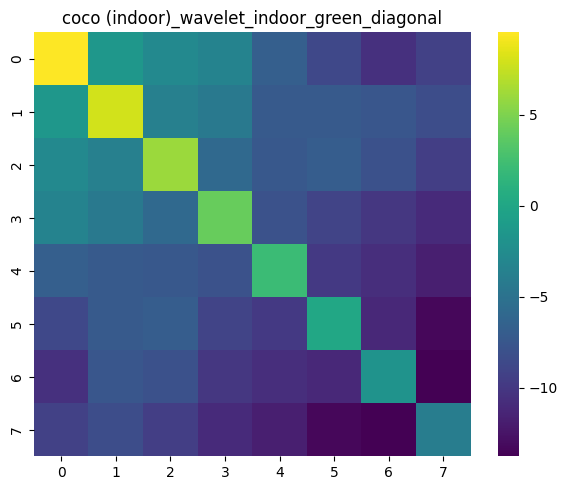

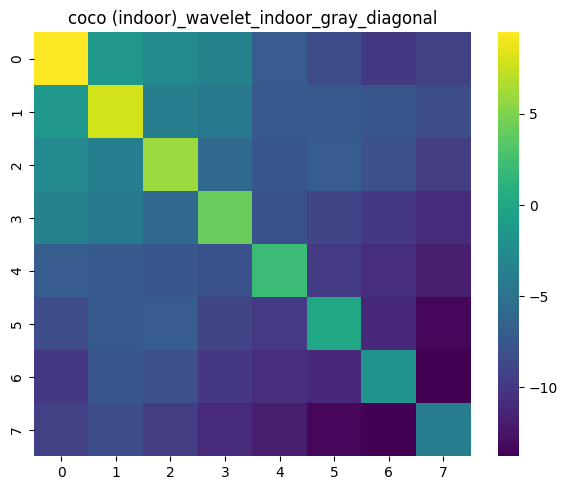

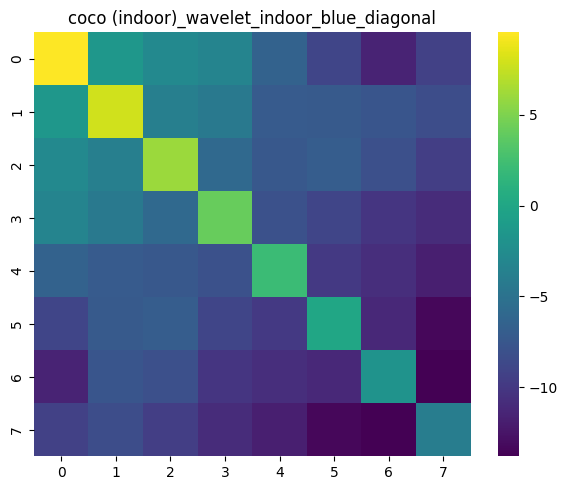

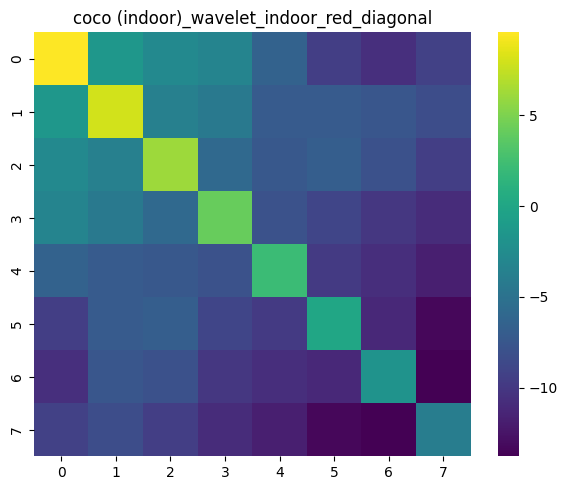

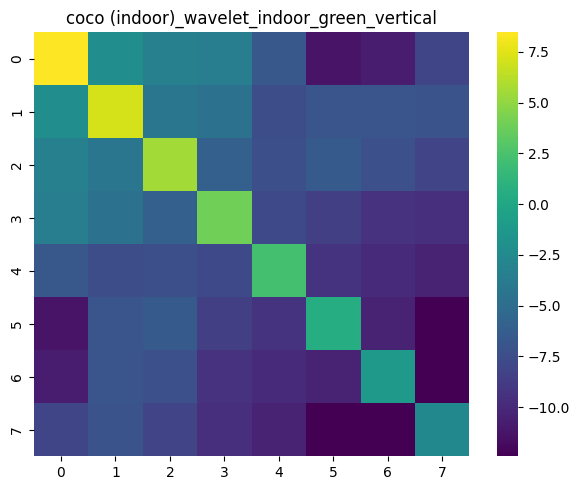

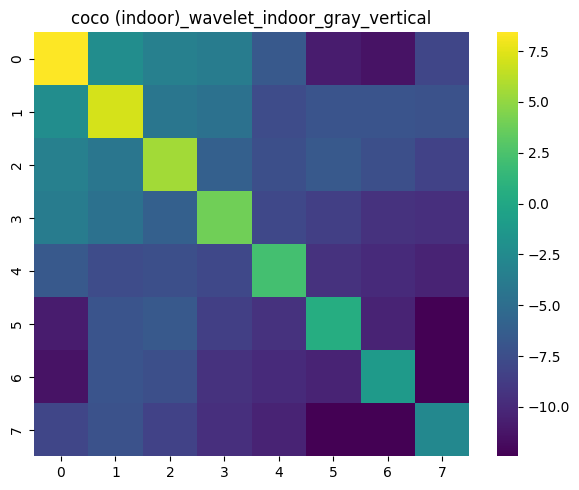

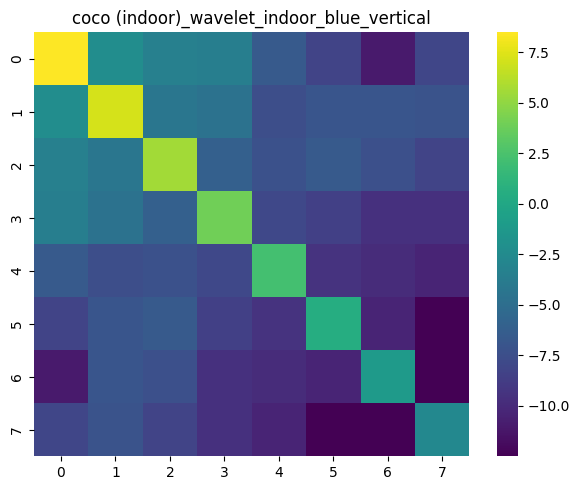

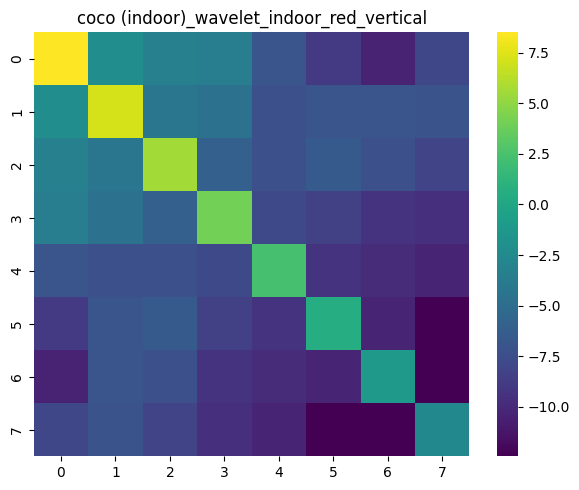

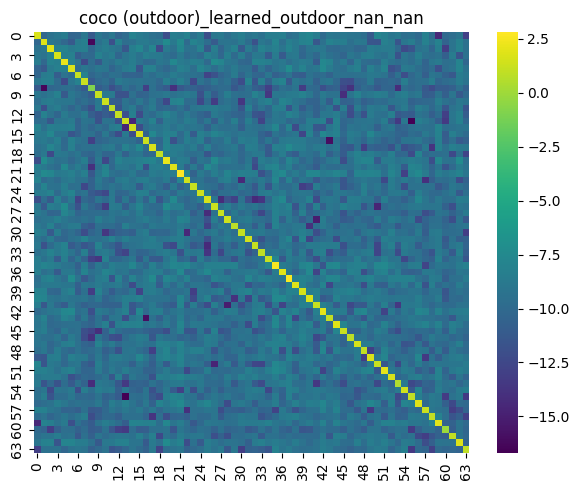

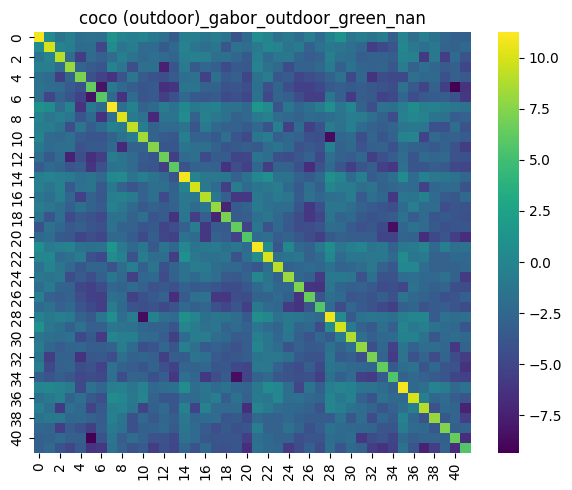

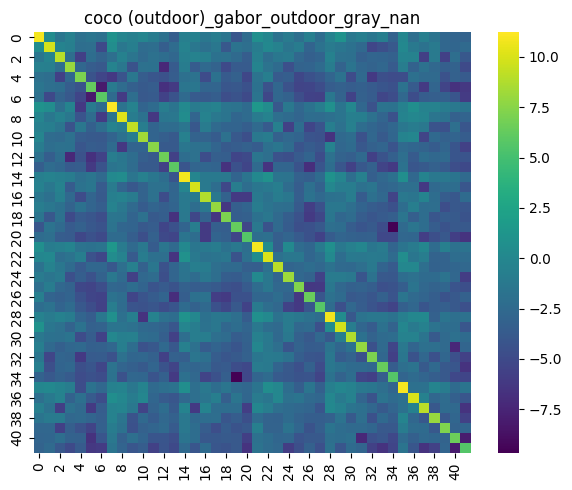

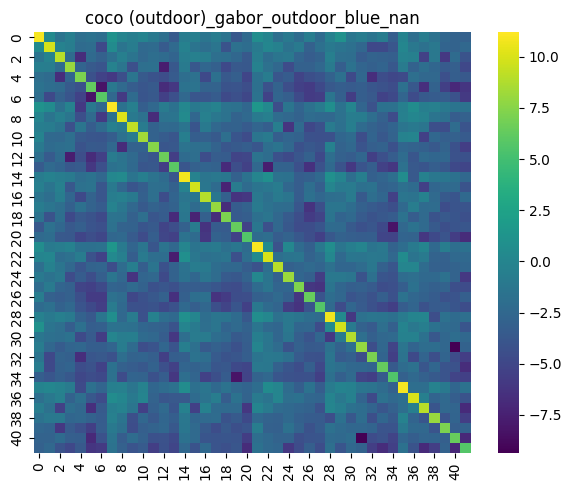

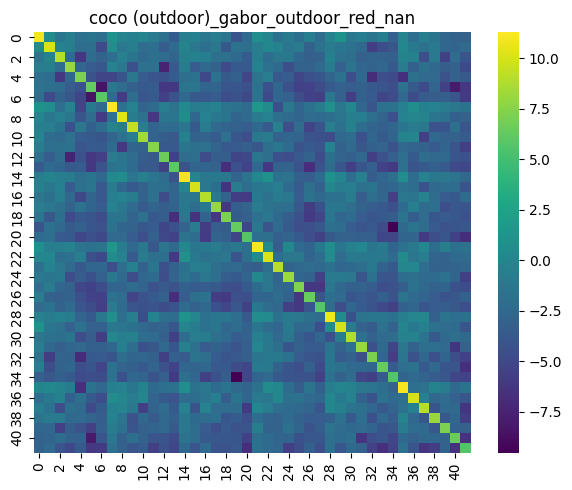

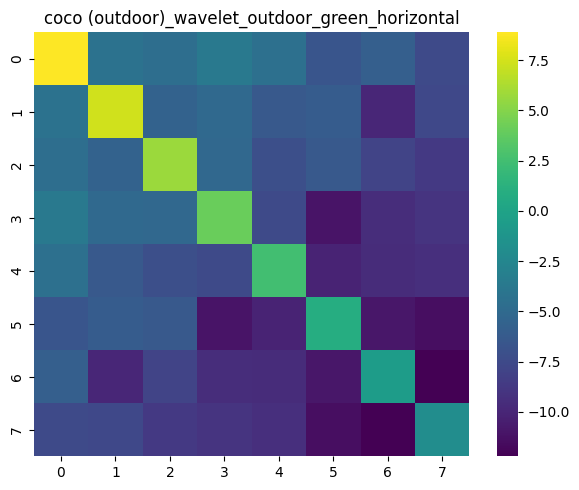

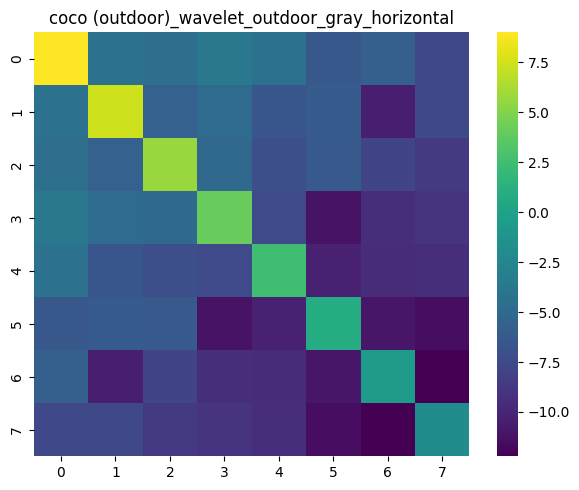

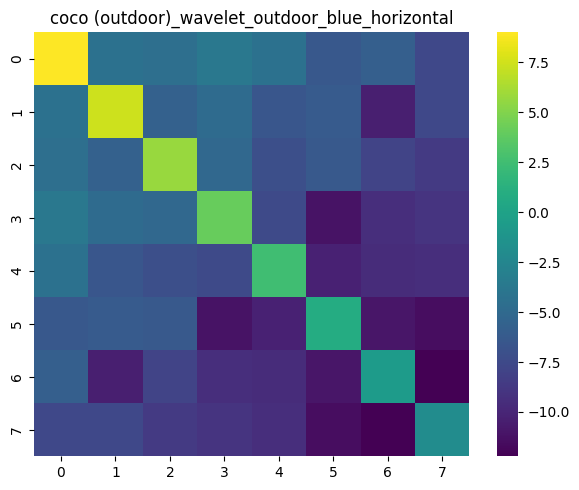

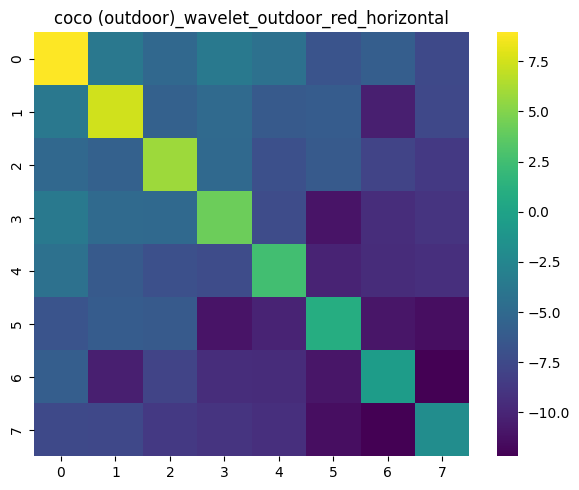

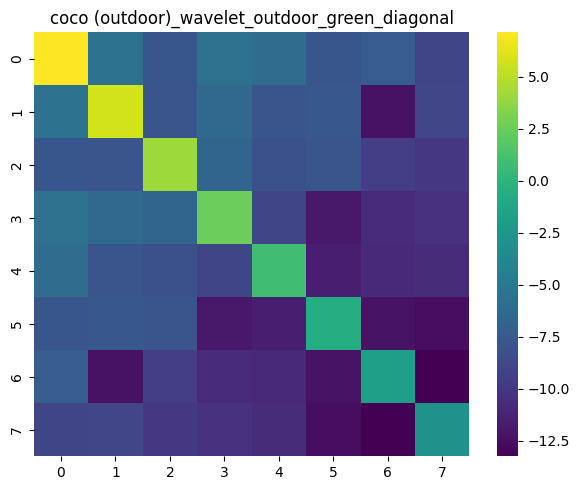

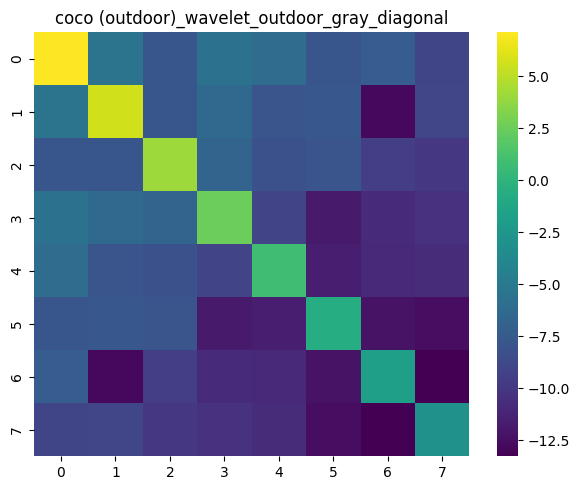

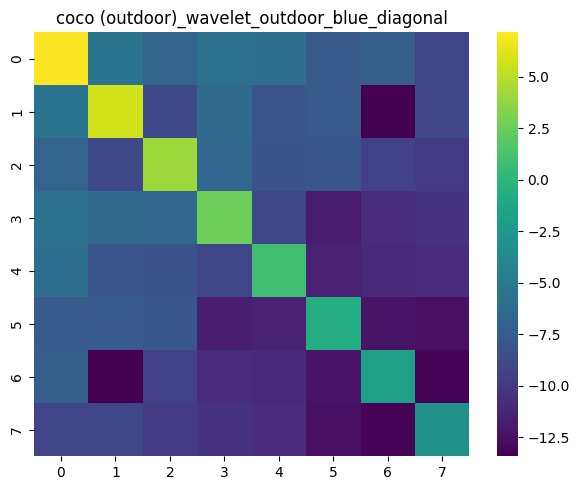

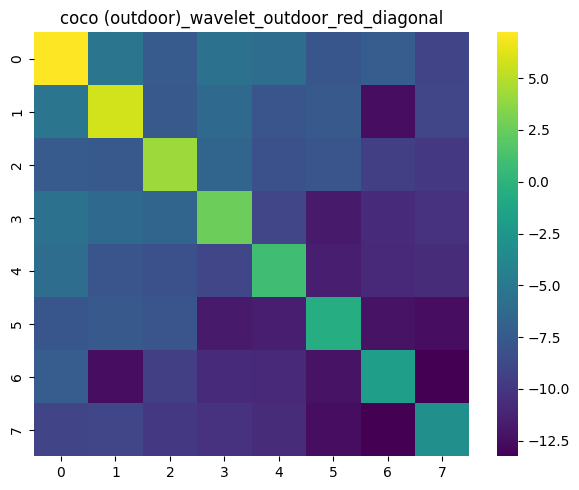

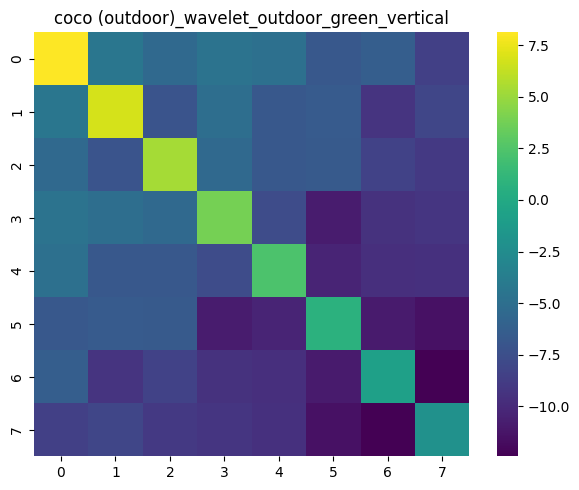

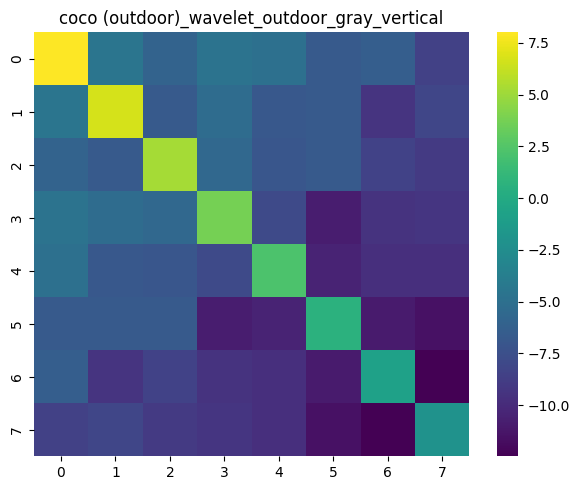

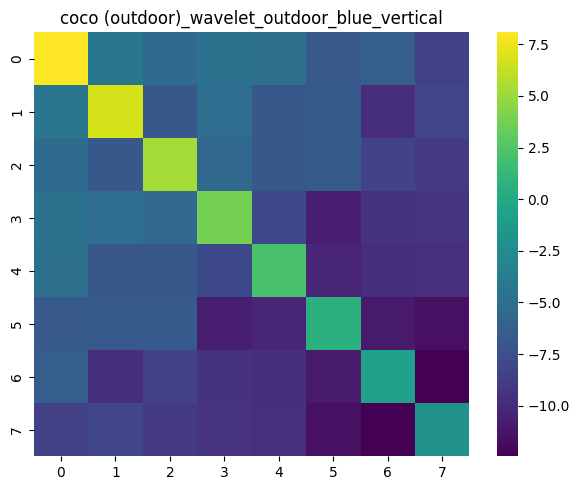

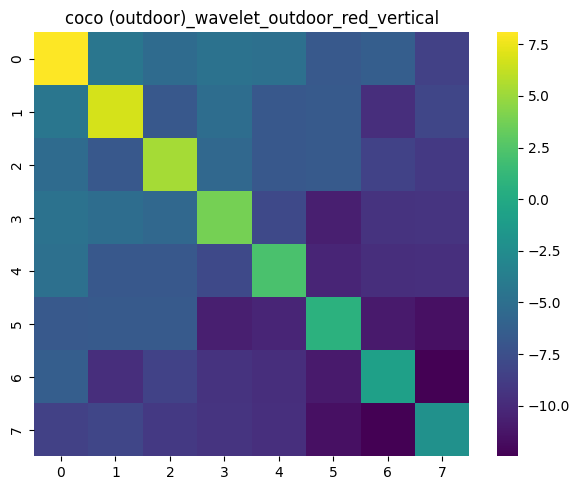

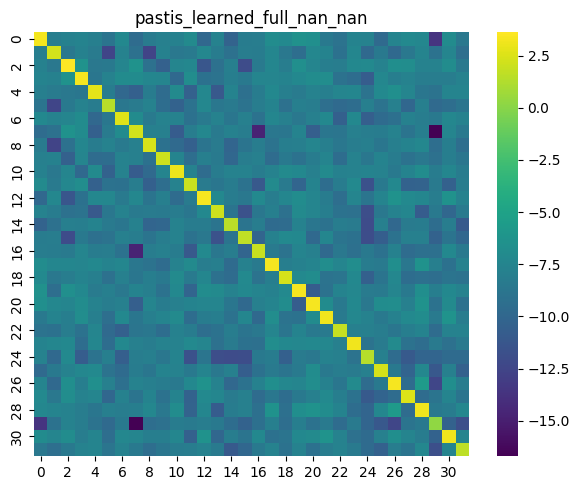

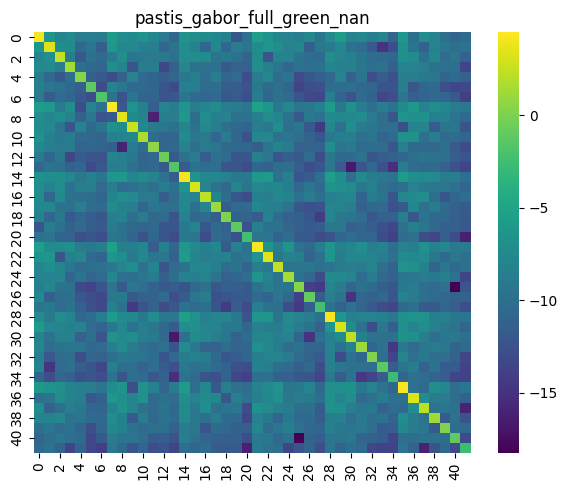

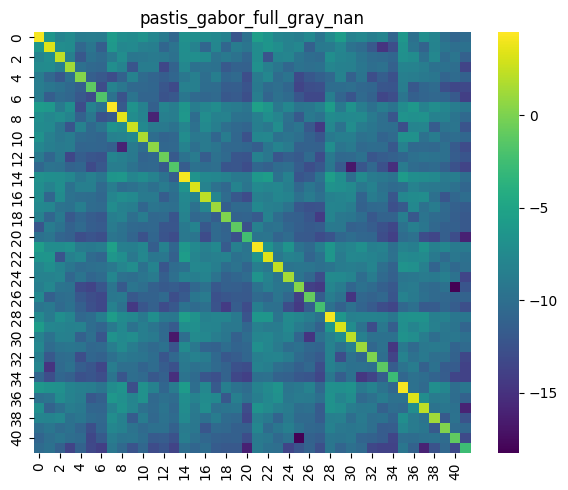

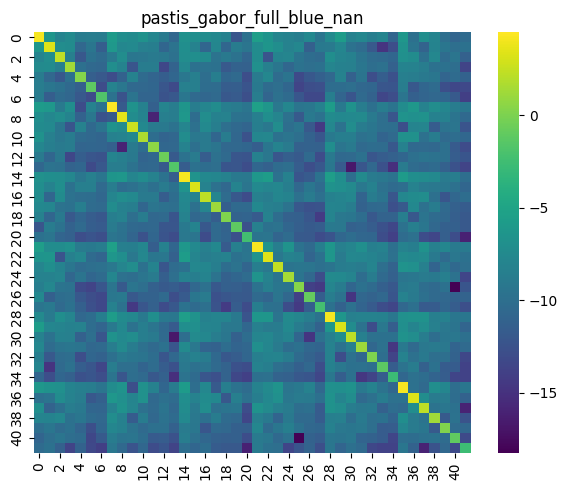

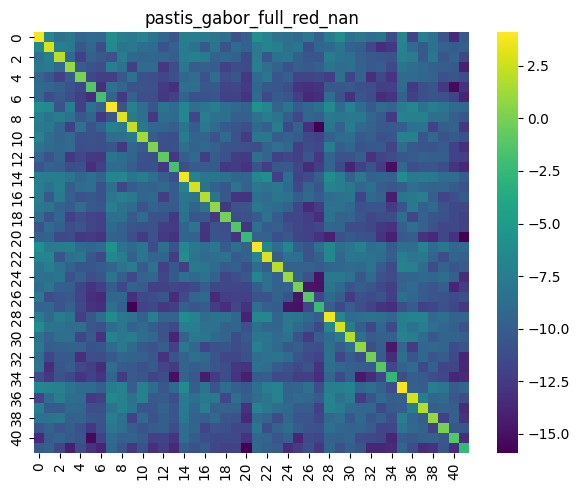

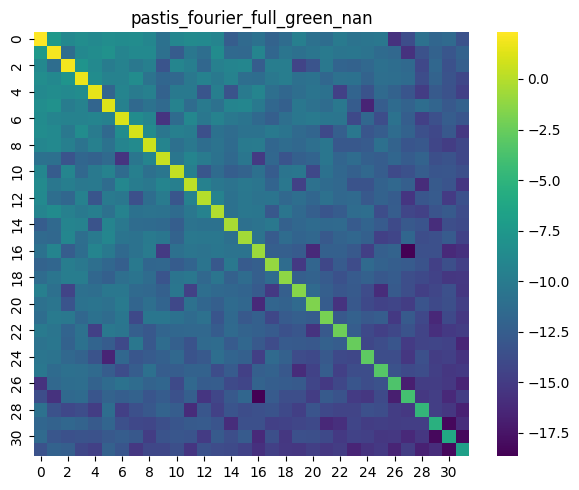

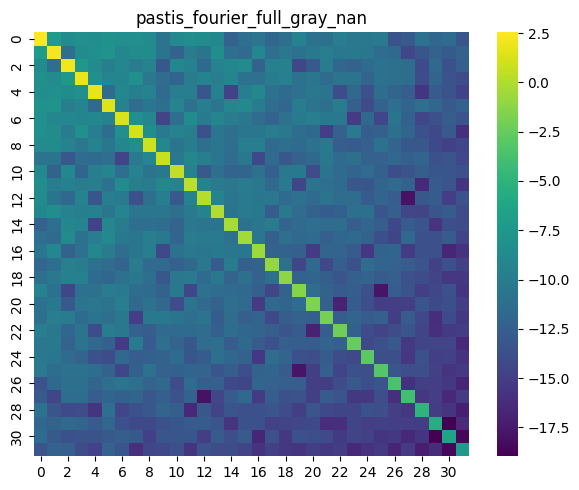

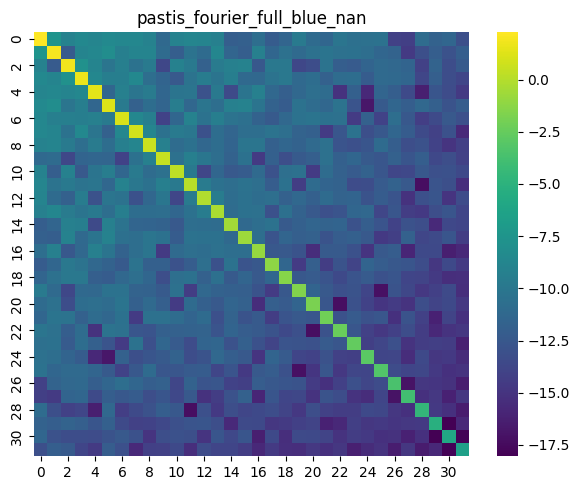

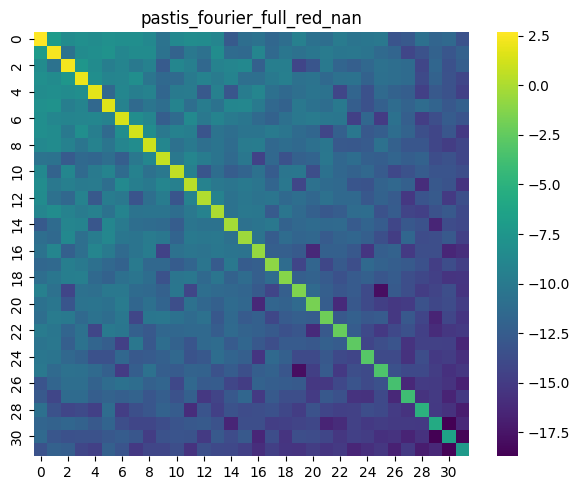

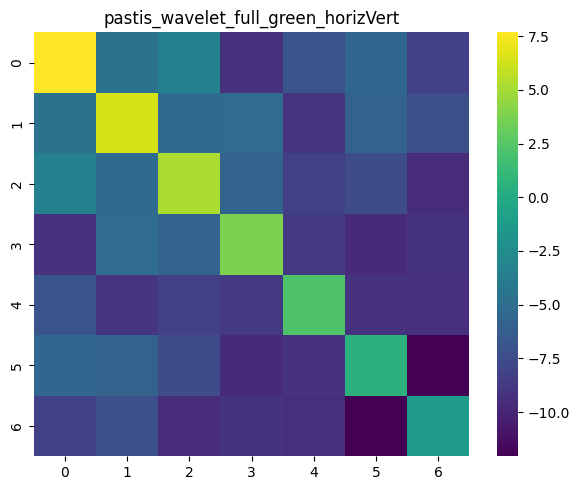

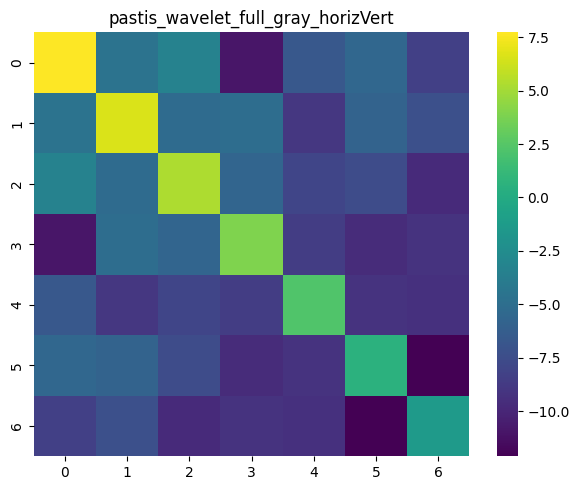

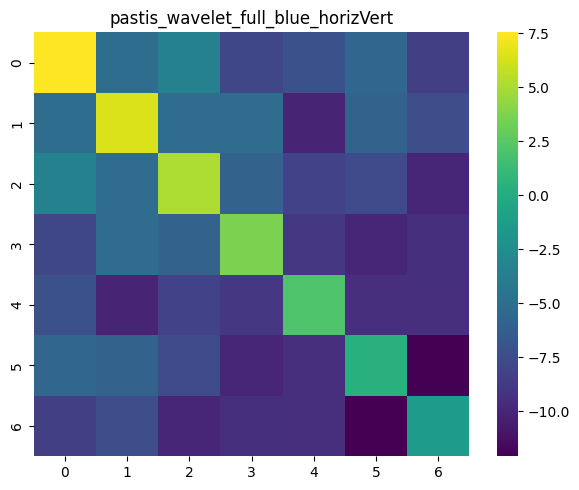

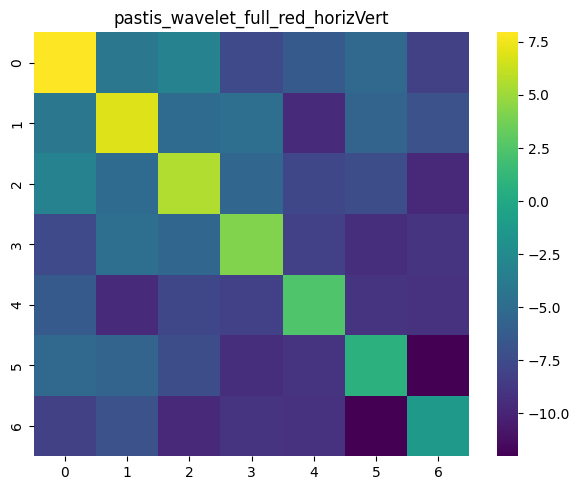

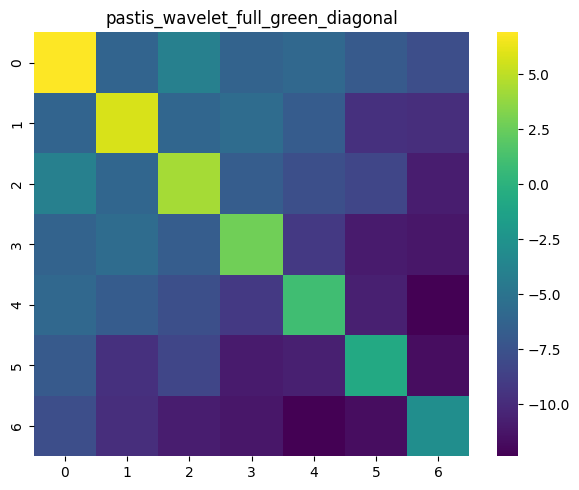

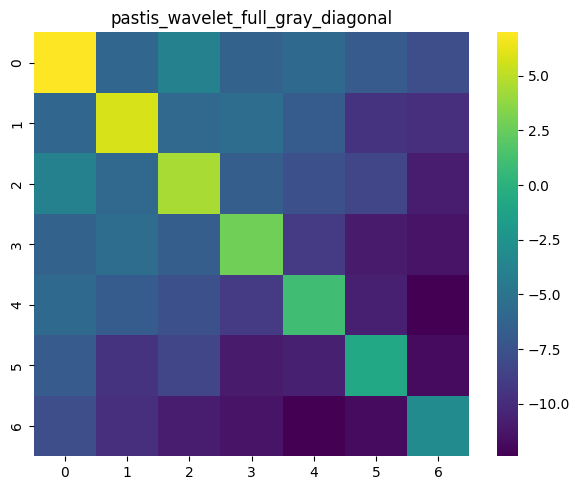

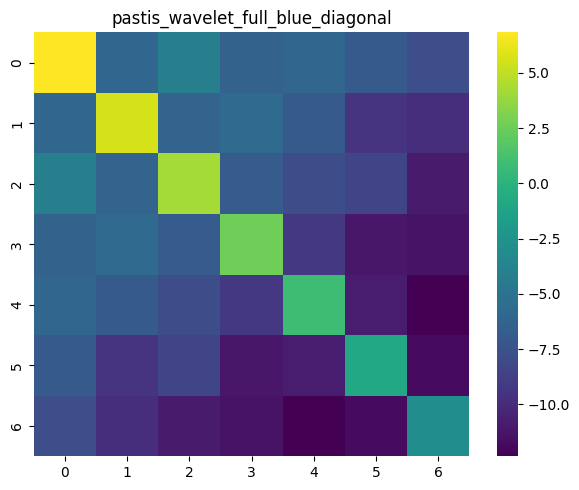

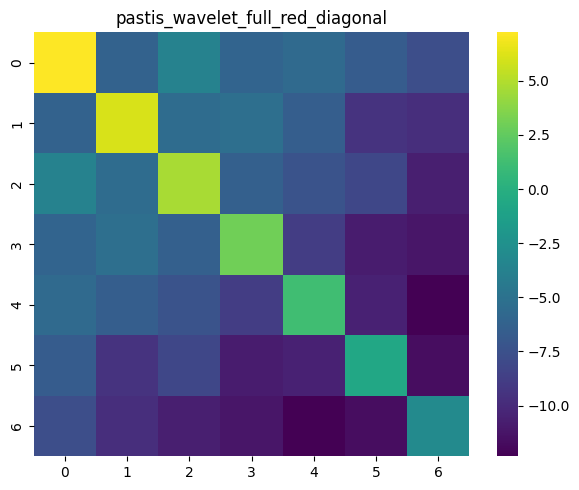

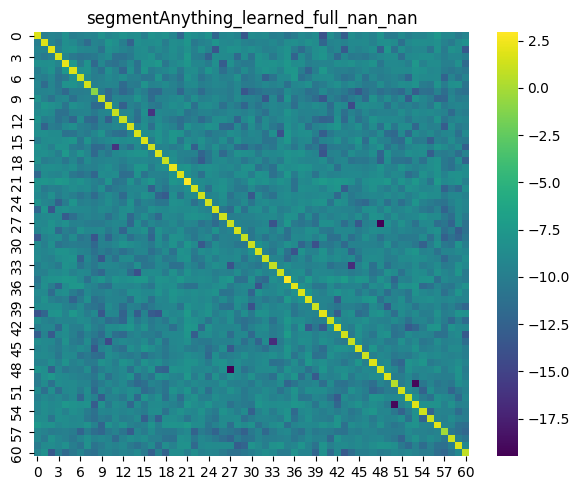

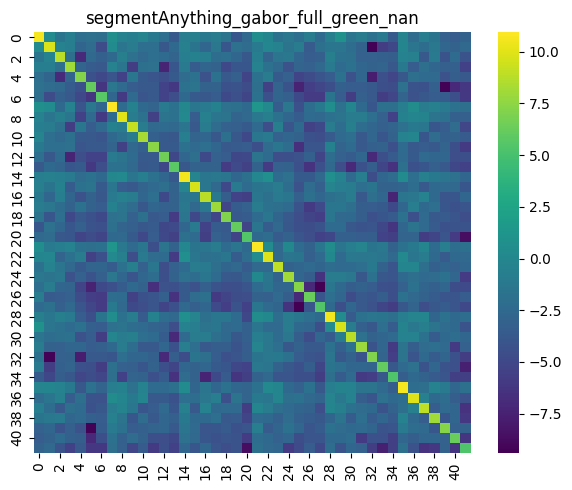

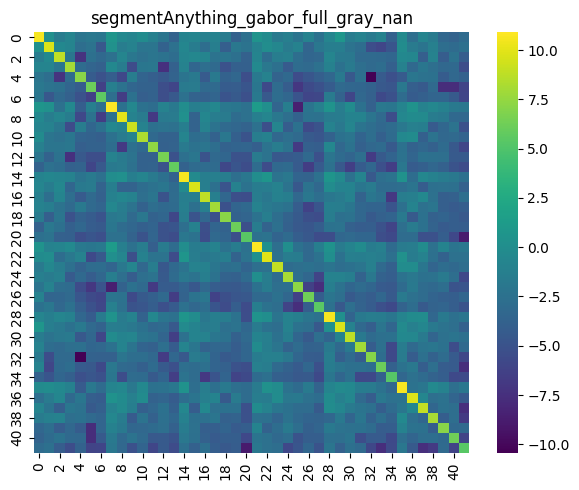

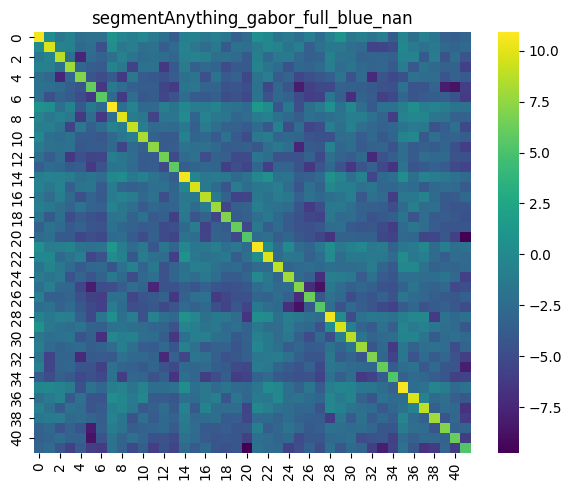

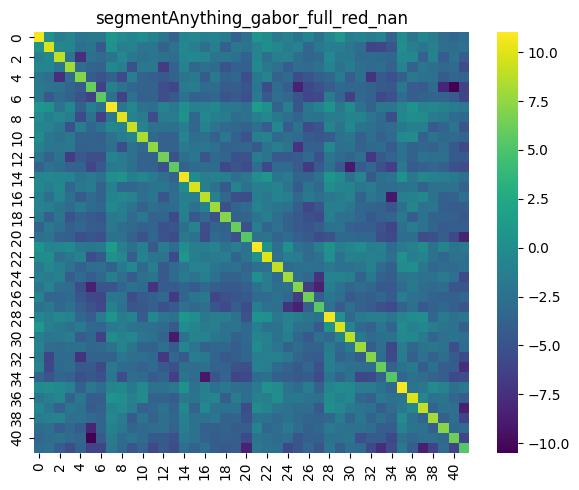

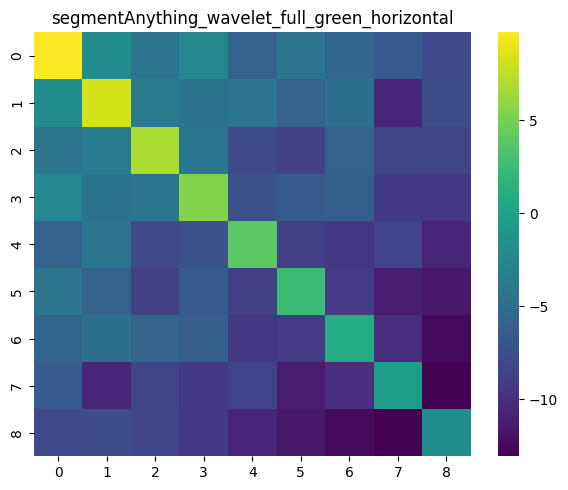

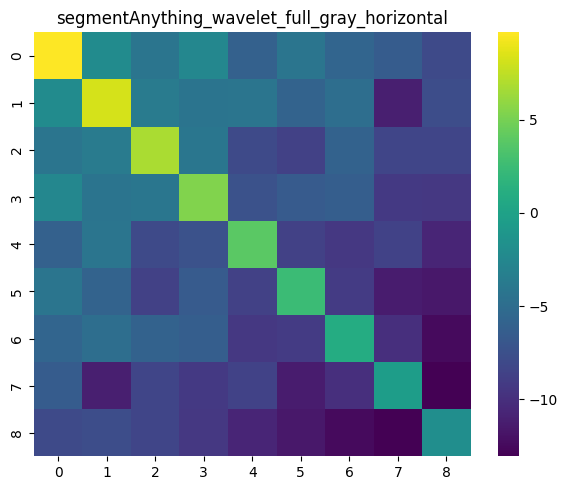

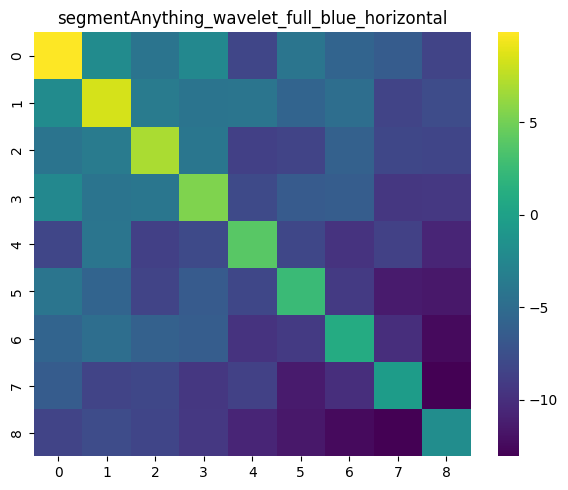

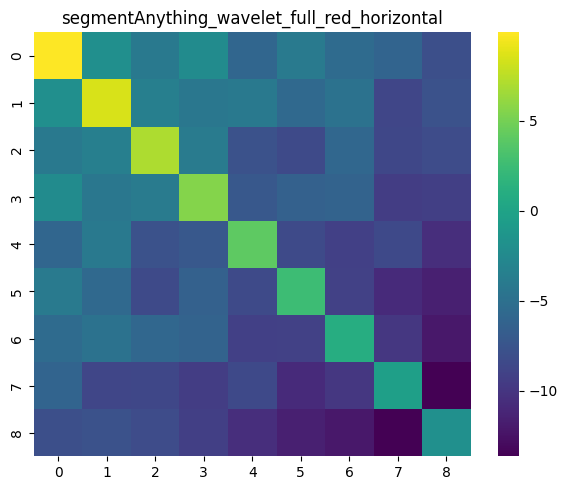

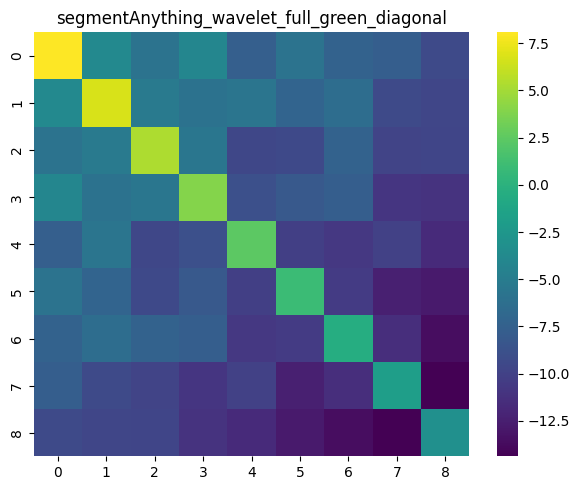

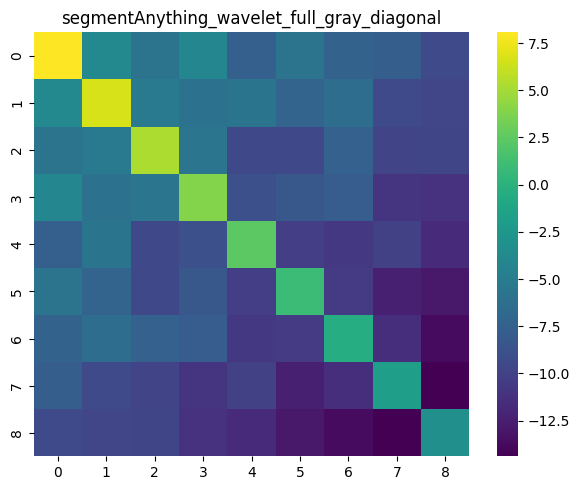

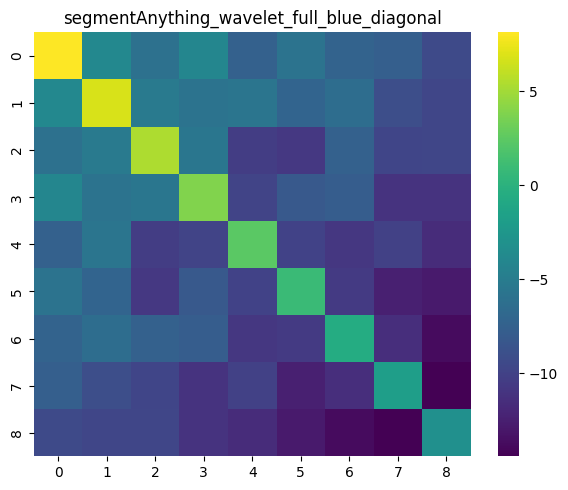

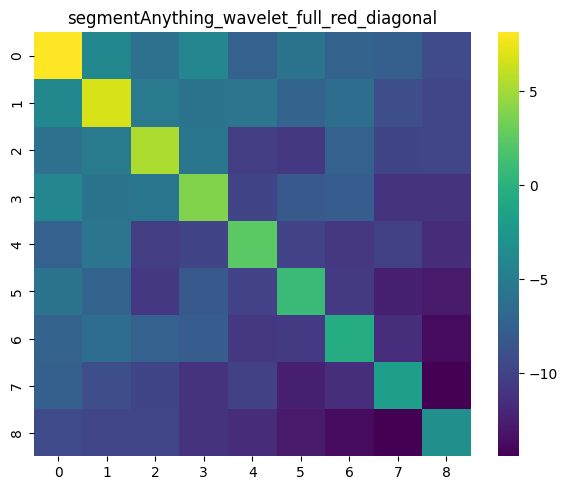

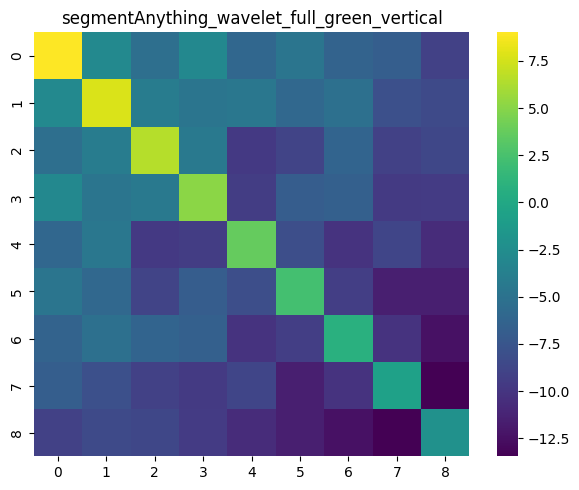

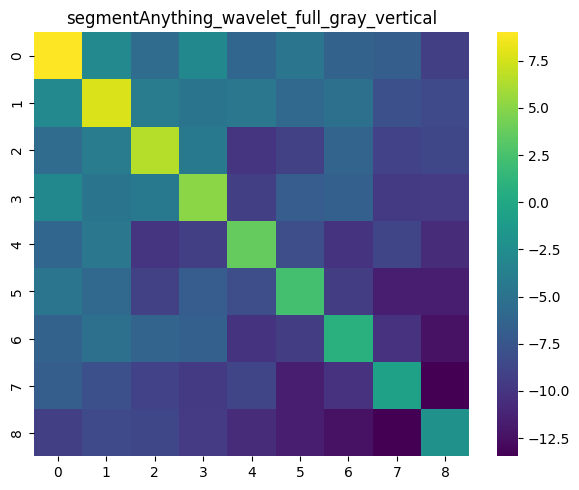

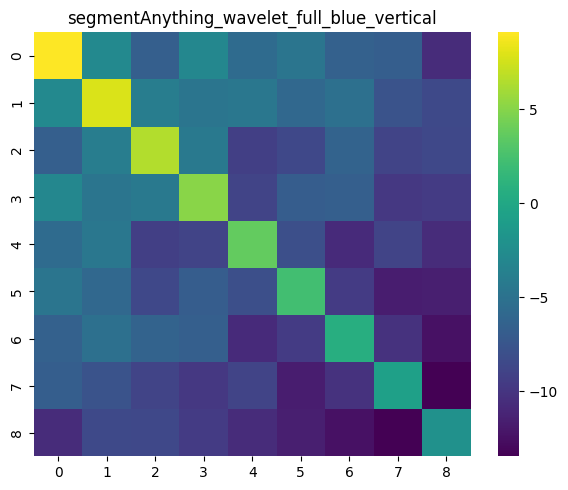

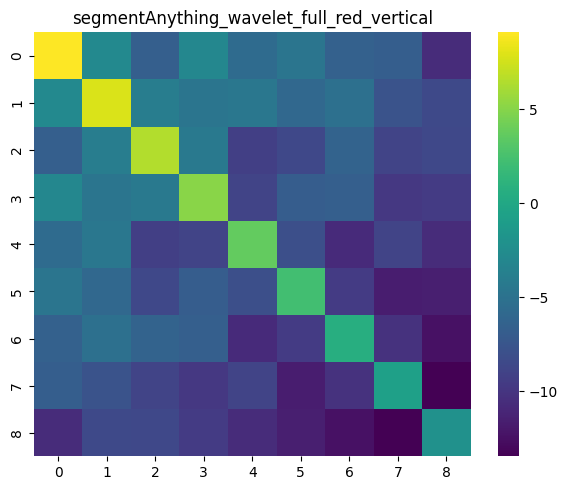

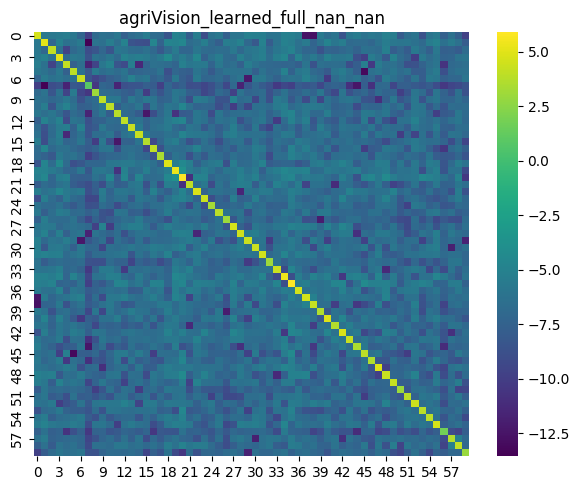

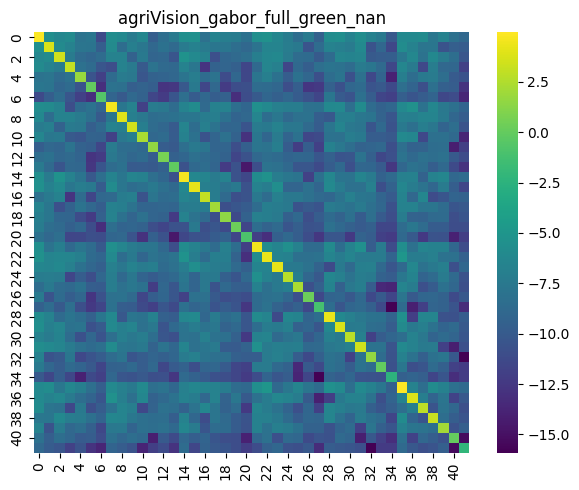

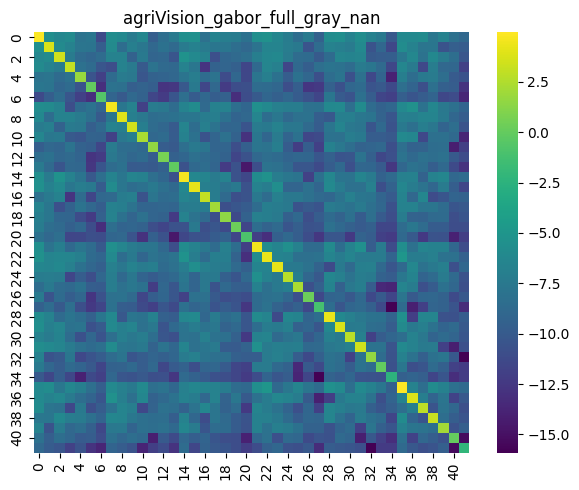

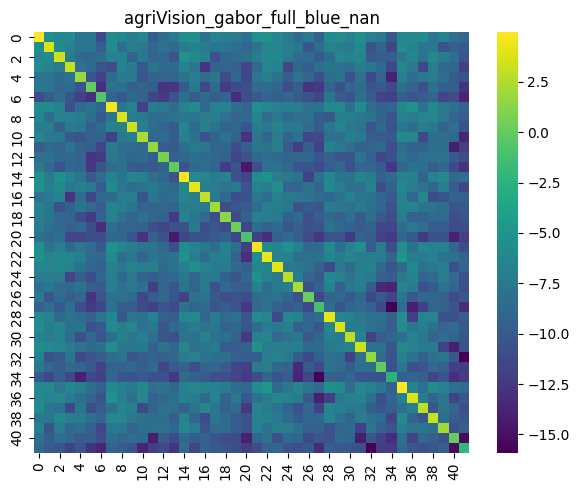

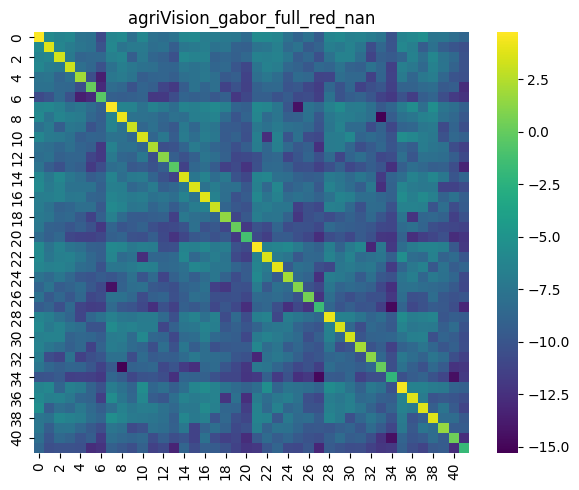

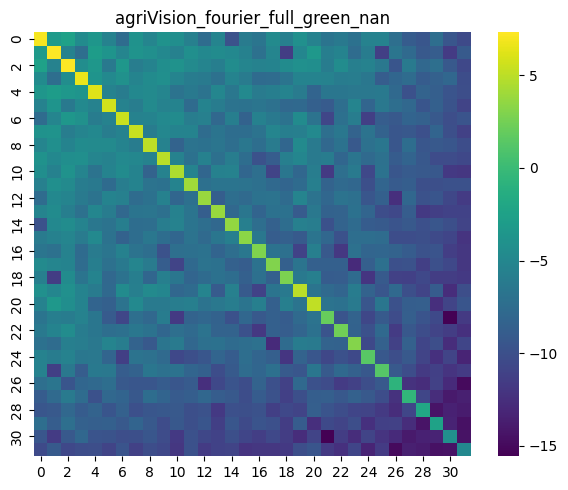

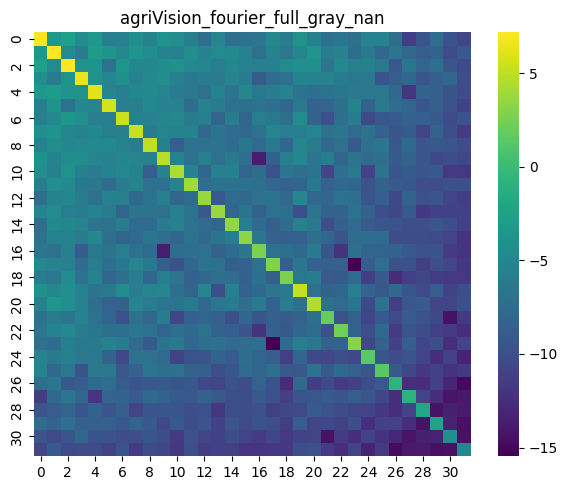

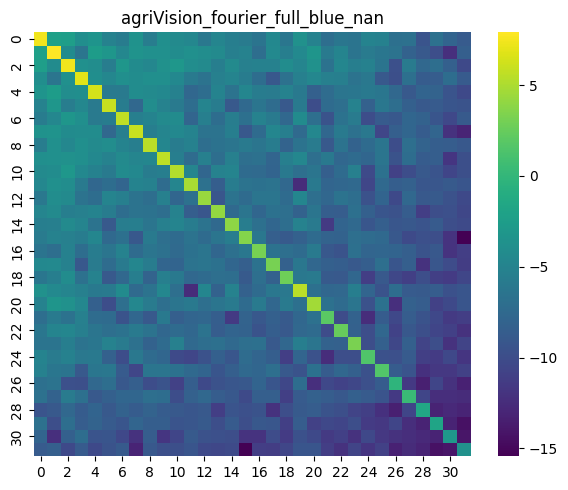

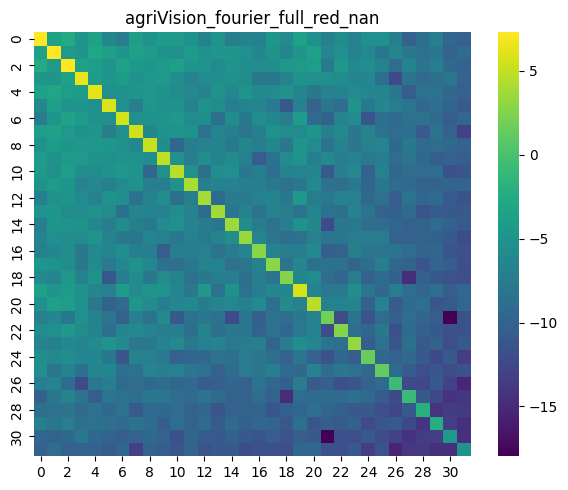

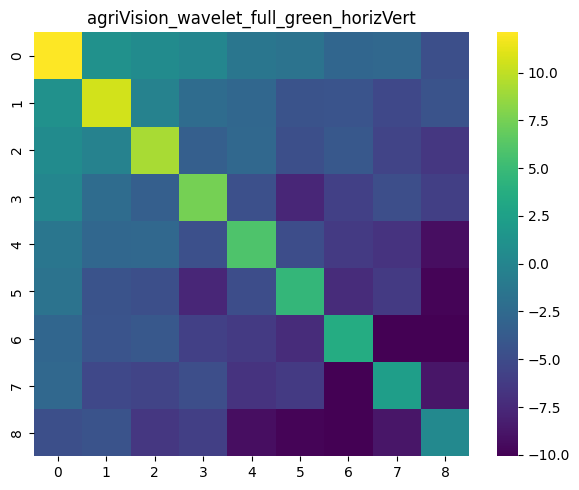

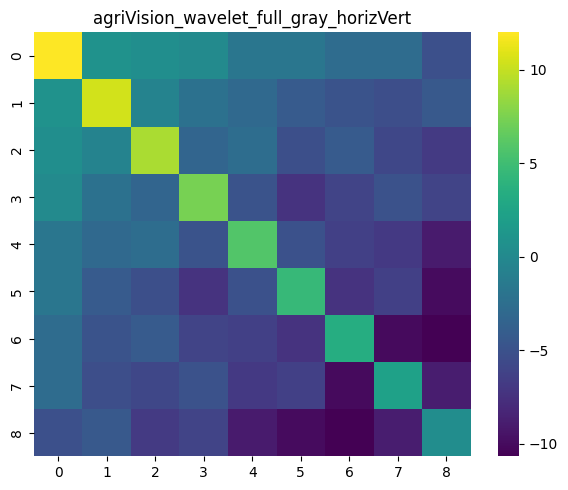

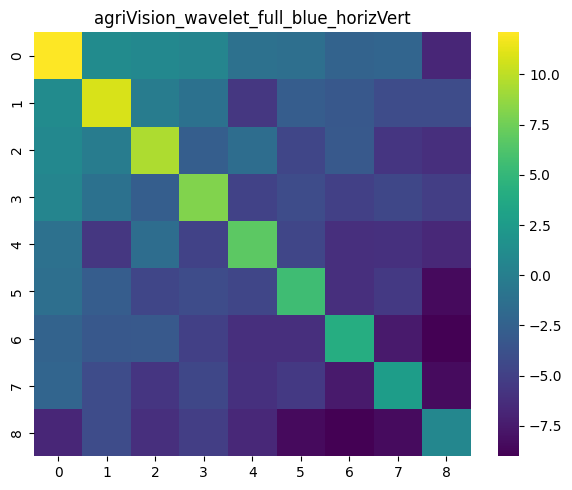

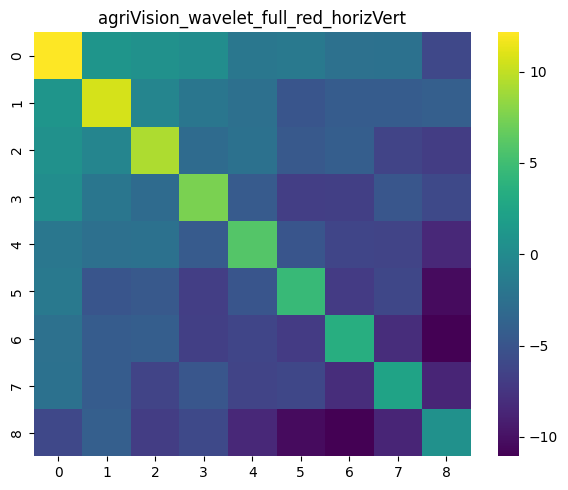

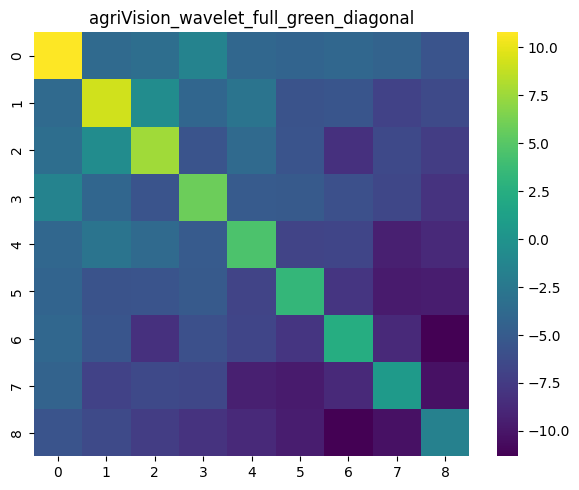

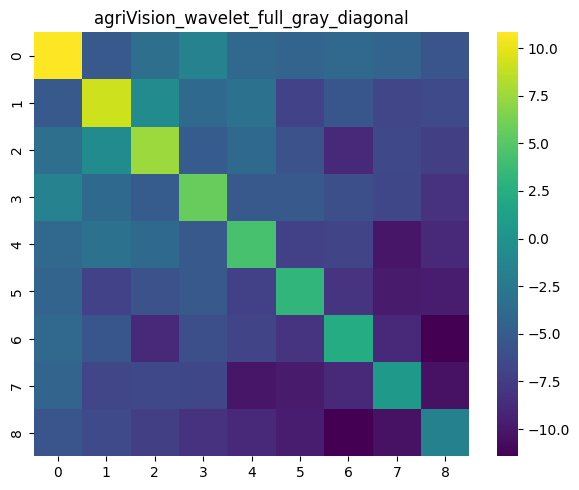

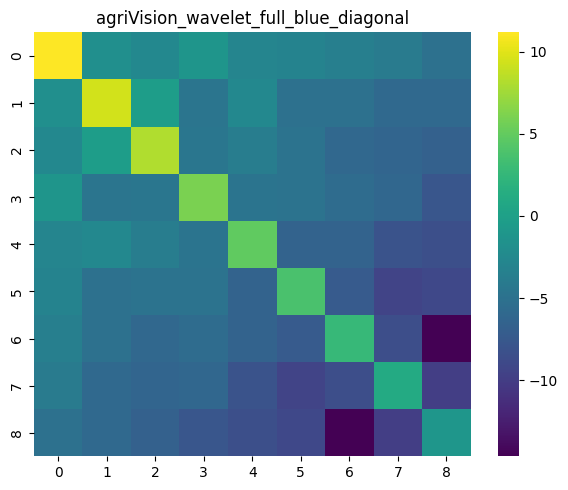

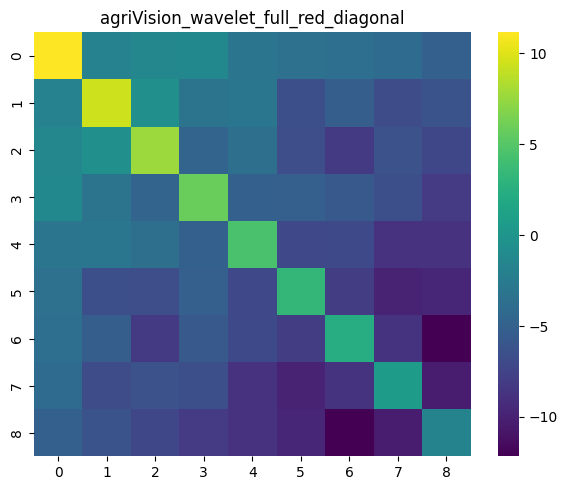

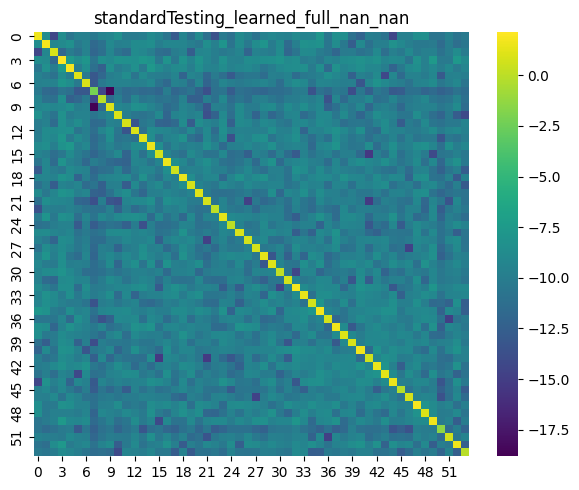

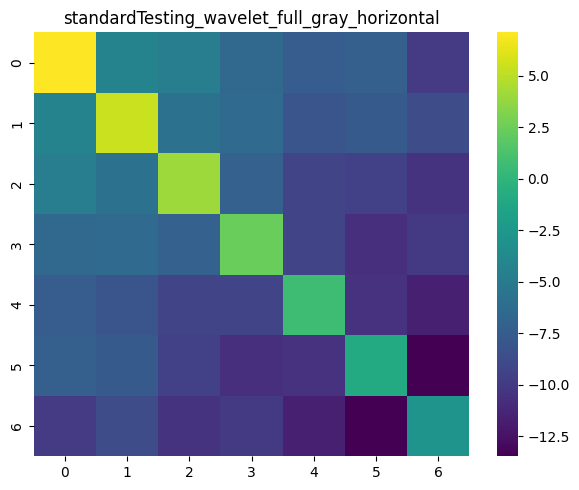

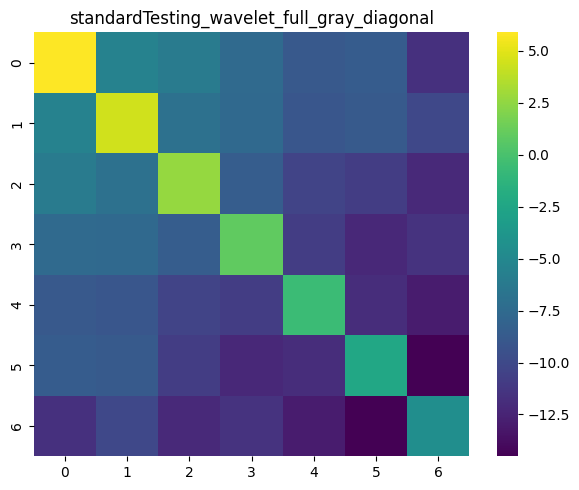

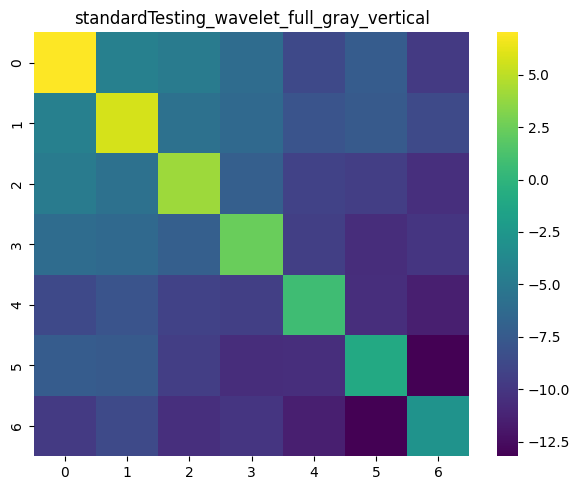

In [58]:
for idx, row in cov_main_df.iterrows():
    cov_matrix = np.array(row['cov_matrix'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(np.log(np.abs(cov_matrix) + 1e-12), cmap='viridis')
    plt.title(f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}")
    plt.tight_layout()
    #filename = f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}_cov_heatmap.png"
    #filename = filename.replace(' ', '_').replace('/', '_')
    #plt.savefig(filename)
    plt.show()
    plt.close()